**importing libraries**

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import NASNetMobile, ResNet152, Xception
import tensorflow as tf
import random
from google.colab import drive
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from catboost import CatBoostClassifier


#mouting google drive
drive.mount('/content/drive')

#setting seed
seed_value = 9557
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

Mounted at /content/drive


**Pre-processing**

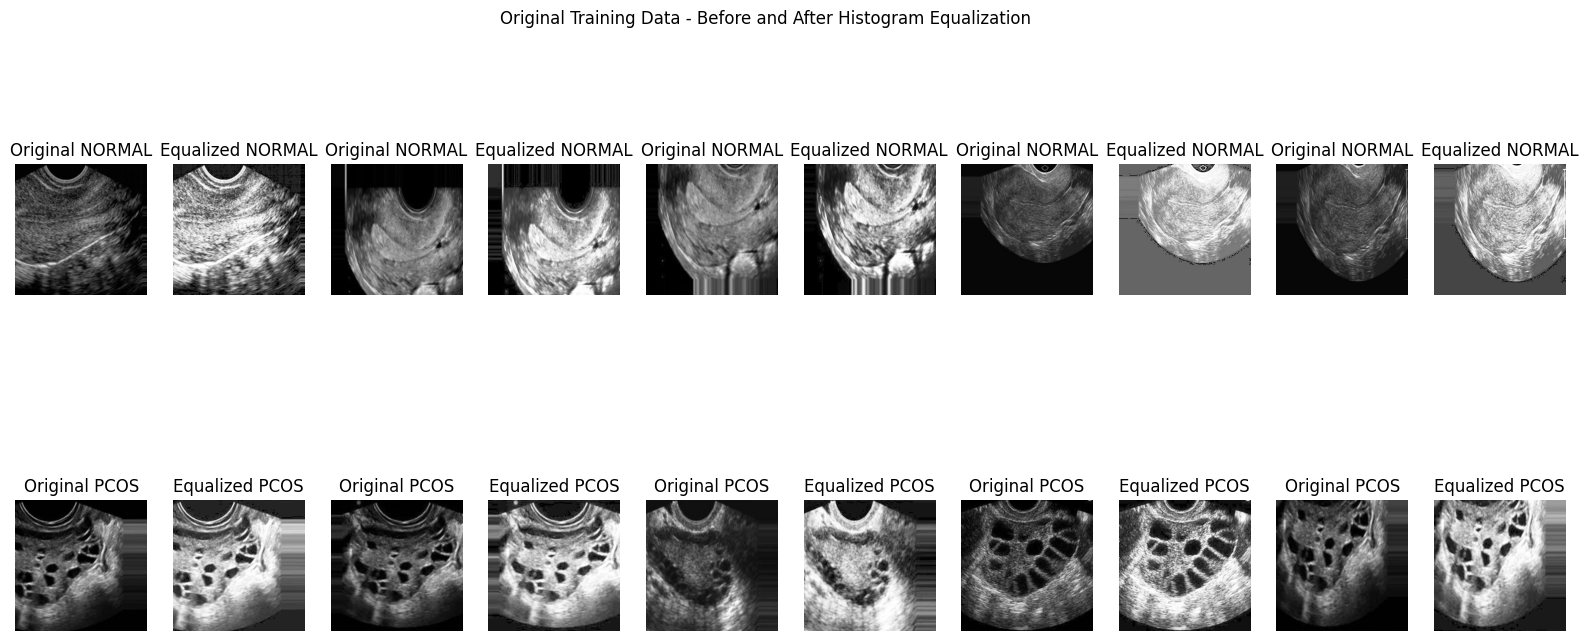

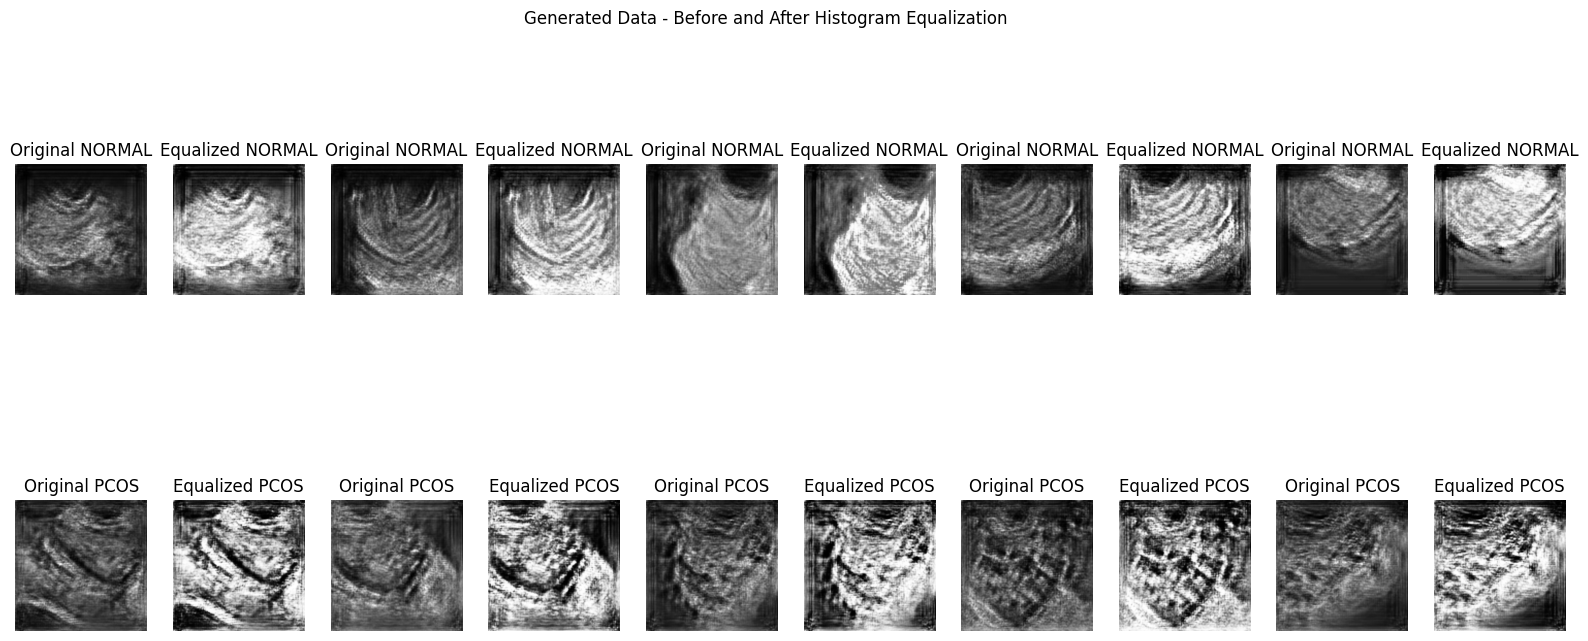

In [ ]:
def load_data(directory, target_size=(224, 224)):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = Image.open(image_path).convert('L')
            image = image.resize(target_size)
            image = np.stack((image,)*3, axis=-1)
            images.append(np.array(image))
            labels.append(class_name)
    return np.array(images), np.array(labels)

#histogram equalisation
def apply_histogram_equalization(image):
    image_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    image_yuv[:,:,0] = cv2.equalizeHist(image_yuv[:,:,0])
    image_equalized = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
    return image_equalized


def visualize_histogram_equalization(images, labels, title):
    classes = np.unique(labels)
    fig, axes = plt.subplots(len(classes), 10, figsize=(20, len(classes)*4))
    fig.suptitle(title)

    for i, class_name in enumerate(classes):
        class_images = images[labels == class_name][:5]
        for j, image in enumerate(class_images):
            axes[i, j*2].imshow(image)
            axes[i, j*2].set_title(f"Original {class_name}")
            axes[i, j*2].axis('off')

            equalized_image = apply_histogram_equalization(image)
            axes[i, j*2 + 1].imshow(equalized_image)
            axes[i, j*2 + 1].set_title(f"Equalized {class_name}")
            axes[i, j*2 + 1].axis('off')

    plt.show()

#loading original data
train_dir = '/content/drive/MyDrive/Dataset/Train'
test_dir = '/content/drive/MyDrive/Dataset/Test'
train_images, train_labels = load_data(train_dir)
test_images, test_labels = load_data(test_dir)

#loading the generated data
generated_data_dir = '/content/drive/MyDrive/AllGenerated2'
generated_images, generated_labels = load_data(generated_data_dir)

visualize_histogram_equalization(train_images, train_labels, "Original Training Data - Before and After Histogram Equalization")

visualize_histogram_equalization(generated_images, generated_labels, "Generated Data - Before and After Histogram Equalization")

equalized_train_images = np.array([apply_histogram_equalization(image) for image in train_images])
equalized_test_images = np.array([apply_histogram_equalization(image) for image in test_images])
equalized_generated_images = np.array([apply_histogram_equalization(image) for image in generated_images])


In [ ]:
#splitting original training data into a new training set and validation set
original_train_images, original_val_images, original_train_labels, original_val_labels = train_test_split(
    equalized_train_images, train_labels, test_size=0.2, random_state=42
)

#combining original training set with generated data
combined_train_images = np.concatenate((original_train_images, equalized_generated_images), axis=0)
combined_train_labels = np.concatenate((original_train_labels, generated_labels), axis=0)

#normalising
def normalize_images(image_list):
    normalized_images = []
    for image in image_list:
        normalized_image = image.astype('float32') / 255.0
        normalized_images.append(normalized_image)
    return np.array(normalized_images)

normalized_train_images = normalize_images(combined_train_images)
normalized_val_images = normalize_images(original_val_images)
normalized_test_images = normalize_images(equalized_test_images)

#label encoding
le = LabelEncoder()
encoded_train_labels = le.fit_transform(combined_train_labels)
encoded_val_labels = le.transform(original_val_labels)
encoded_test_labels = le.transform(test_labels)


In [ ]:
class_labels = dict(zip(le.classes_, le.transform(le.classes_)))
print("Classes and their corresponding labels:")
for label, encoded in class_labels.items():
    print(f"{label}: {encoded}")

Classes and their corresponding labels:
NORMAL: 0
PCOS: 1


In [ ]:
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(normalized_train_images, encoded_train_labels, batch_size=32)
val_generator = val_datagen.flow(normalized_val_images, encoded_val_labels, batch_size=32, shuffle=False)
test_generator = test_datagen.flow(normalized_test_images, encoded_test_labels, batch_size=32, shuffle=False)


**EDA**

Number of samples in the training set: 6034
Number of samples in the validation set: 318
Number of samples in the test set: 398
Number of samples in the generated set: 4764


<ipython-input-41-a102f19b4636>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette='viridis')


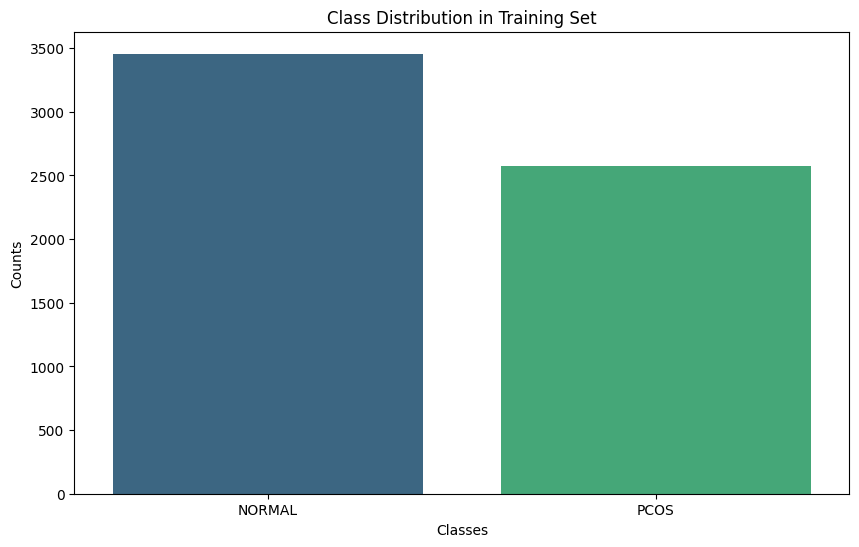

<ipython-input-41-a102f19b4636>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette='viridis')


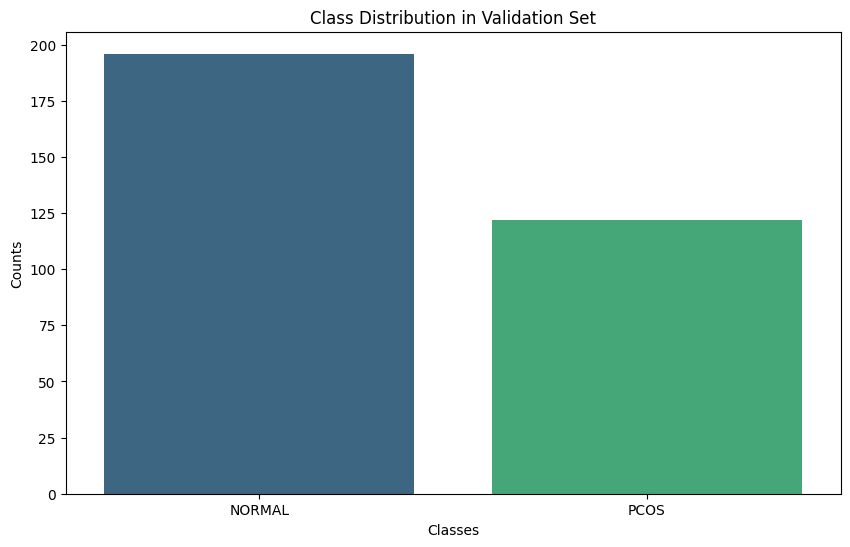

<ipython-input-41-a102f19b4636>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette='viridis')


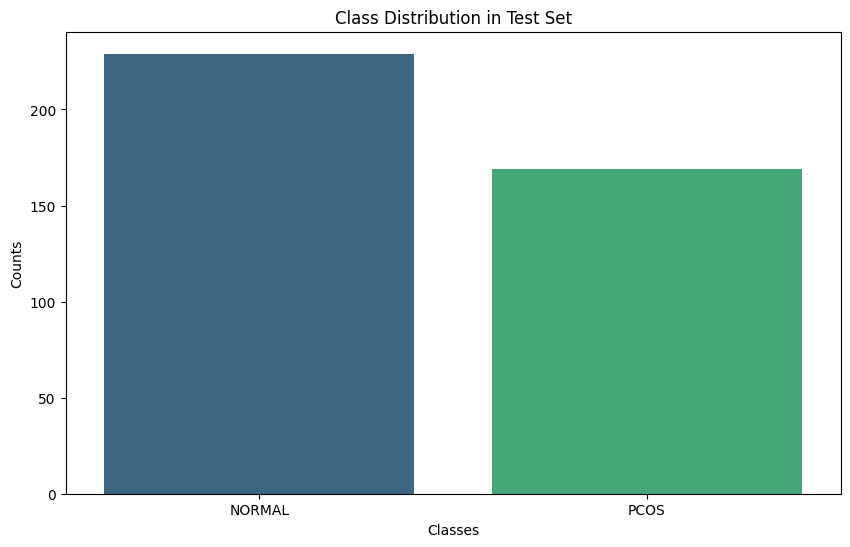

<ipython-input-41-a102f19b4636>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette='viridis')


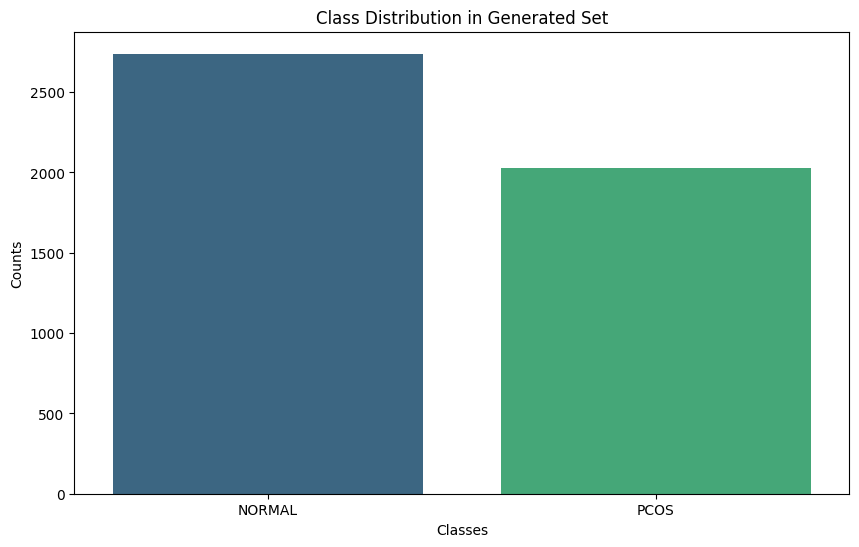

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


train_count = len(normalized_train_images)
val_count = len(normalized_val_images)
test_count = len(normalized_test_images)
generated_count = len(equalized_generated_images)

print(f"Number of samples in the training set: {train_count}")
print(f"Number of samples in the validation set: {val_count}")
print(f"Number of samples in the test set: {test_count}")
print(f"Number of samples in the generated set: {generated_count}")


train_class_distribution = np.unique(combined_train_labels, return_counts=True)
val_class_distribution = np.unique(original_val_labels, return_counts=True)
test_class_distribution = np.unique(test_labels, return_counts=True)
generated_class_distribution = np.unique(generated_labels, return_counts=True)


def plot_class_distribution(class_distribution, set_name):
    classes, counts = class_distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=classes, y=counts, palette='viridis')
    plt.title(f'Class Distribution in {set_name} Set')
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.show()

plot_class_distribution(train_class_distribution, 'Training')
plot_class_distribution(val_class_distribution, 'Validation')
plot_class_distribution(test_class_distribution, 'Test')
plot_class_distribution(generated_class_distribution, 'Generated')


Number of samples in the training set: 6034
Number of samples in the validation set: 318
Number of samples in the test set: 398
Number of samples in the generated set: 4764


<ipython-input-42-0c804558f2a6>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette='viridis', ax=ax)
<ipython-input-42-0c804558f2a6>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette='viridis', ax=ax)
<ipython-input-42-0c804558f2a6>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette='viridis', ax=ax)
<ipython-input-42-0c804558f2a6>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` vari

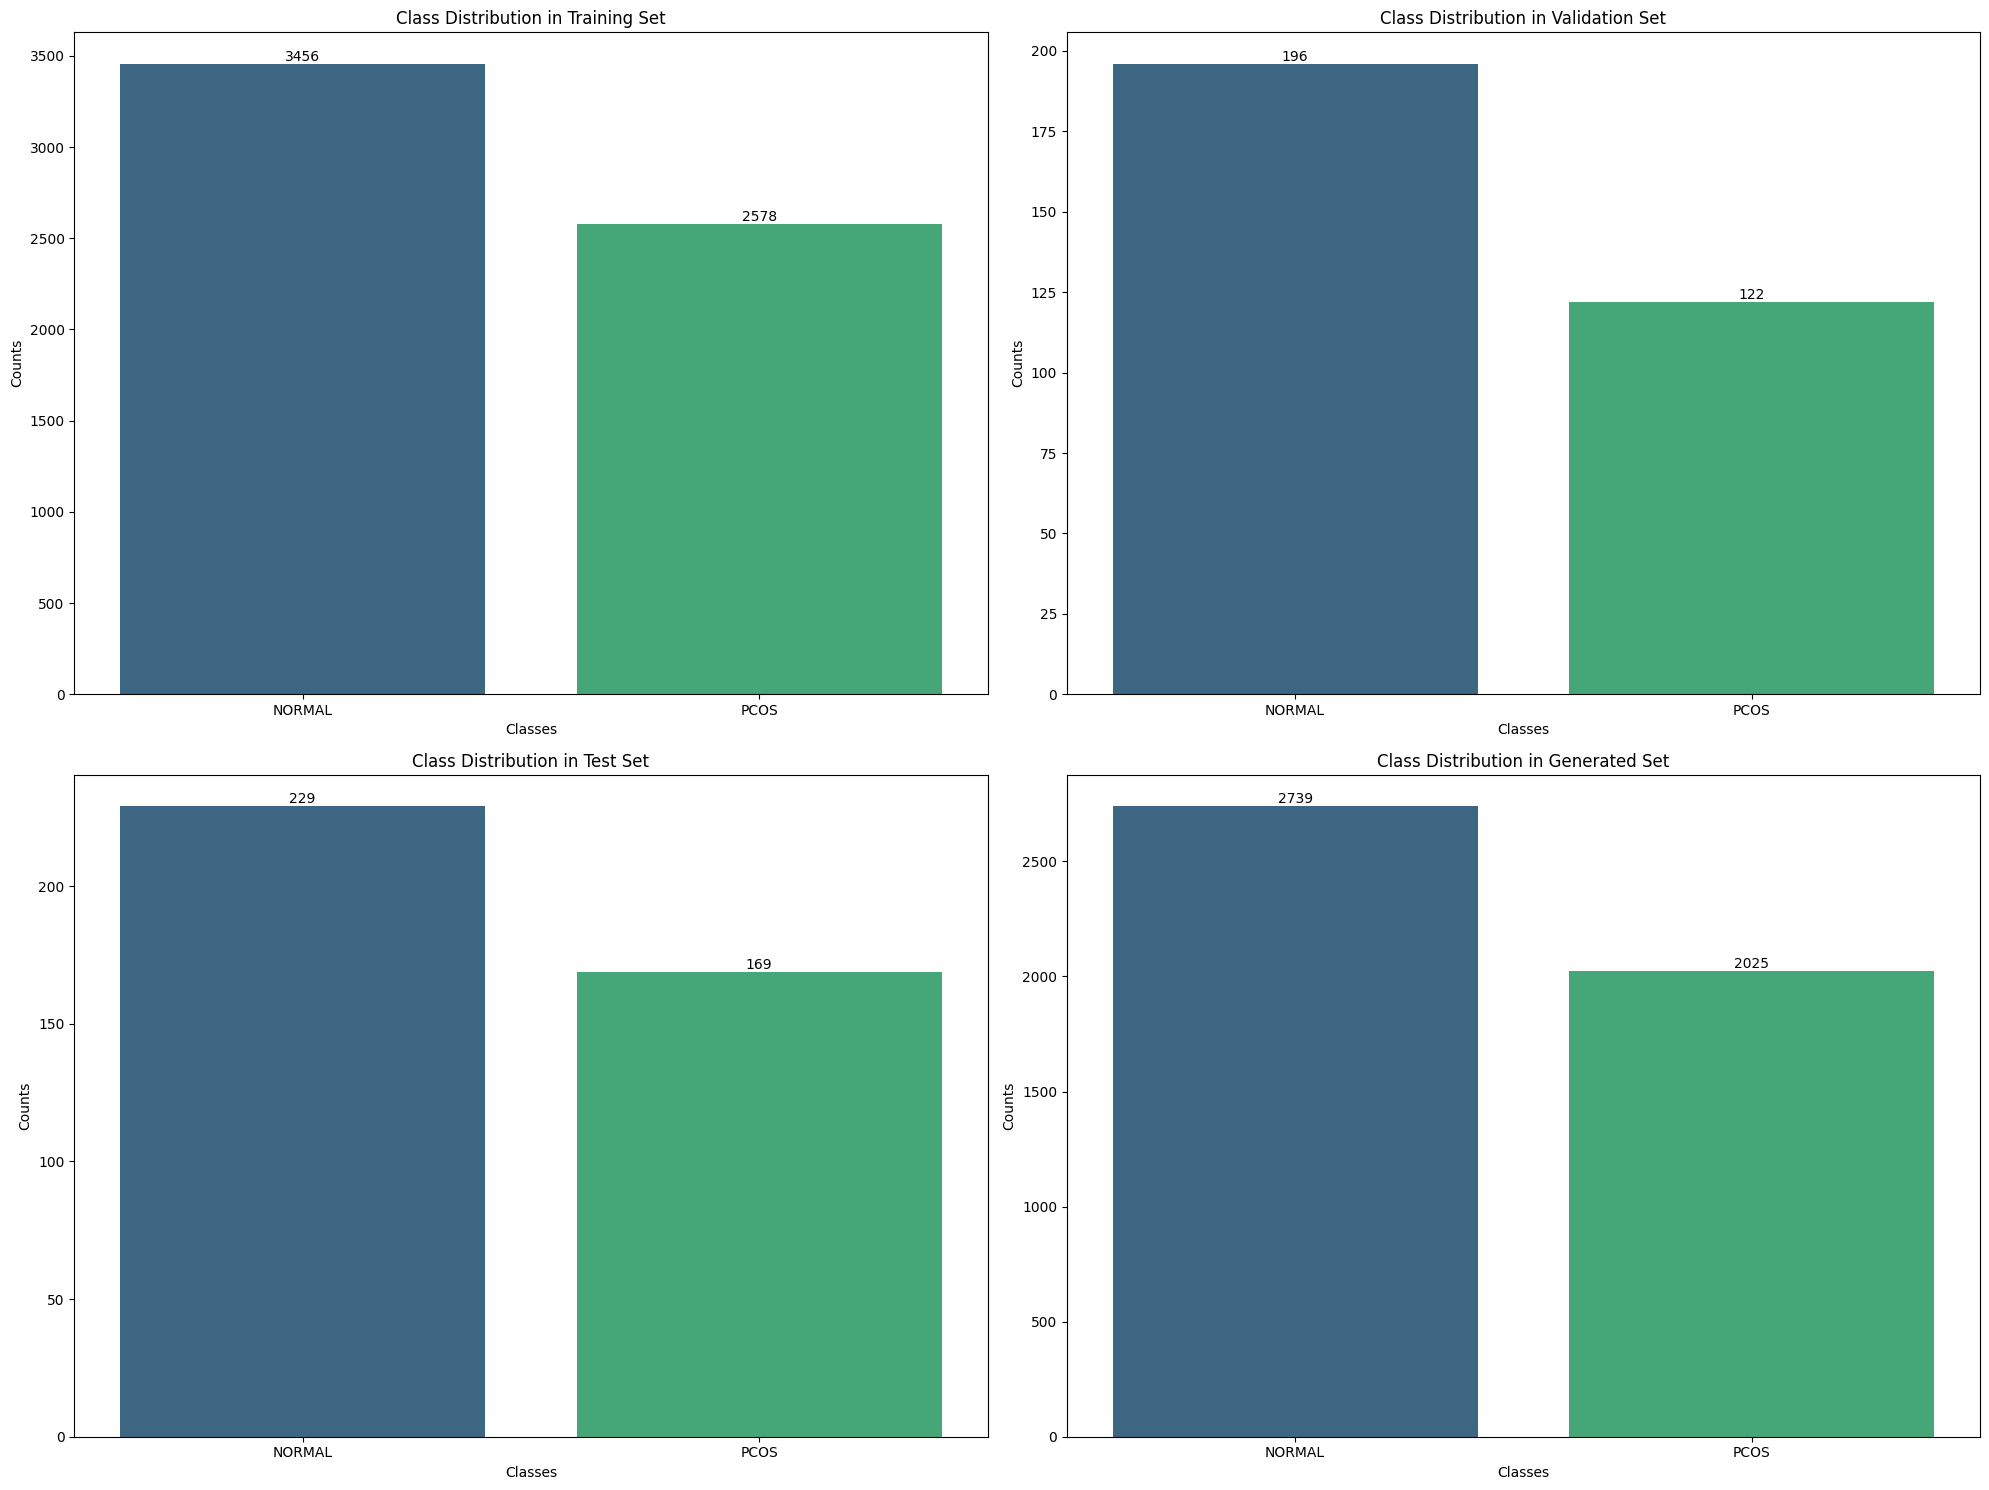

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

train_count = len(normalized_train_images)
val_count = len(normalized_val_images)
test_count = len(normalized_test_images)
generated_count = len(equalized_generated_images)

print(f"Number of samples in the training set: {train_count}")
print(f"Number of samples in the validation set: {val_count}")
print(f"Number of samples in the test set: {test_count}")
print(f"Number of samples in the generated set: {generated_count}")

#counting the distribution of classes in each set
train_class_distribution = np.unique(combined_train_labels, return_counts=True)
val_class_distribution = np.unique(original_val_labels, return_counts=True)
test_class_distribution = np.unique(test_labels, return_counts=True)
generated_class_distribution = np.unique(generated_labels, return_counts=True)

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

def plot_class_distribution(ax, class_distribution, set_name):
    classes, counts = class_distribution
    sns.barplot(x=classes, y=counts, palette='viridis', ax=ax)
    ax.set_title(f'Class Distribution in {set_name} Set')
    ax.set_xlabel('Classes')
    ax.set_ylabel('Counts')
    for i in ax.containers:
        ax.bar_label(i,)

plot_class_distribution(axes[0, 0], train_class_distribution, 'Training')
plot_class_distribution(axes[0, 1], val_class_distribution, 'Validation')
plot_class_distribution(axes[1, 0], test_class_distribution, 'Test')
plot_class_distribution(axes[1, 1], generated_class_distribution, 'Generated')

plt.tight_layout()
plt.show()


In [ ]:
#original data count
import numpy as np

original_train_count = len(train_images)
original_test_count = len(test_images)

original_train_class_distribution = np.unique(train_labels, return_counts=True)
original_test_class_distribution = np.unique(test_labels, return_counts=True)

print(f"Number of samples in the original training set: {original_train_count}")
print(f"Number of samples in the original test set: {original_test_count}")

print("\nClass distribution in the original training set:")
for class_name, count in zip(original_train_class_distribution[0], original_train_class_distribution[1]):
    print(f"Class {class_name}: {count} samples")

print("\nClass distribution in the original test set:")
for class_name, count in zip(original_test_class_distribution[0], original_test_class_distribution[1]):
    print(f"Class {class_name}: {count} samples")


Number of samples in the original training set: 1588
Number of samples in the original test set: 398

Class distribution in the original training set:
Class NORMAL: 913 samples
Class PCOS: 675 samples

Class distribution in the original test set:
Class NORMAL: 229 samples
Class PCOS: 169 samples


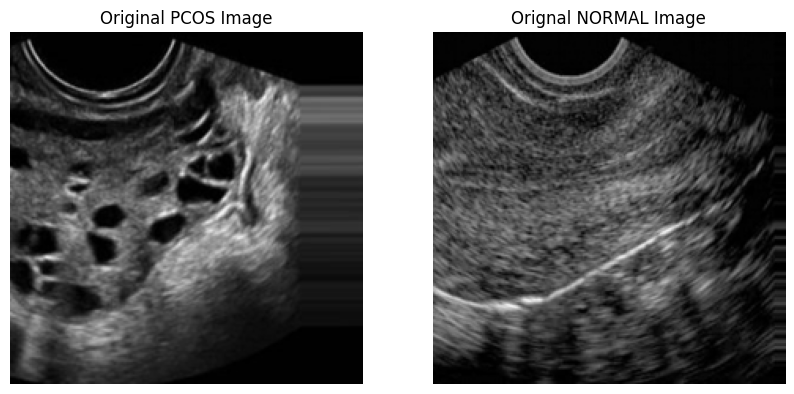

In [ ]:
import matplotlib.pyplot as plt

pcos_index = np.where(train_labels == 'PCOS')[0][0]
normal_index = np.where(train_labels == 'NORMAL')[0][0]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(train_images[pcos_index].squeeze(), cmap='gray')
plt.title('Original PCOS Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(train_images[normal_index].squeeze(), cmap='gray')
plt.title('Orignal NORMAL Image')
plt.axis('off')

plt.show()


**NasNetMobile**

In [ ]:

base_model_nasnet_mobile = NASNetMobile(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

for layer in base_model_nasnet_mobile.layers:
    layer.trainable = False

x = base_model_nasnet_mobile.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(le.classes_), activation='softmax')(x)

model_nasnet_mobile = Model(inputs=base_model_nasnet_mobile.input, outputs=predictions)
model_nasnet_mobile.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_nasnet_mobile.summary()


19993432/19993432 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv1 (Conv2D)         (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 stem_bn1 (BatchNormalizati  (None, 111, 111, 32)         128       ['stem_conv1[0][0]']          
 on)                                                                                              
                                                                                                  
 activation (Activation)     

In [ ]:
#training the model with the new training set and validate on the validation set
history_nasnet_mobile = model_nasnet_mobile.fit(
    train_generator,
    steps_per_epoch=len(normalized_train_images) // 32,
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(normalized_val_images) // 32
)

Epoch 1/10
188/188 [==============================] - 54s 219ms/step - loss: 0.0965 - accuracy: 0.9630 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 2/10
188/188 [==============================] - 33s 174ms/step - loss: 0.0079 - accuracy: 0.9993 - val_loss: 6.6293e-04 - val_accuracy: 1.0000
Epoch 3/10
188/188 [==============================] - 34s 181ms/step - loss: 0.0058 - accuracy: 0.9988 - val_loss: 7.6827e-04 - val_accuracy: 1.0000
Epoch 4/10
188/188 [==============================] - 33s 176ms/step - loss: 0.0051 - accuracy: 0.9983 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 5/10
188/188 [==============================] - 34s 180ms/step - loss: 0.0049 - accuracy: 0.9980 - val_loss: 0.0135 - val_accuracy: 0.9931
Epoch 6/10
188/188 [==============================] - 33s 173ms/step - loss: 0.0036 - accuracy: 0.9993 - val_loss: 5.0802e-05 - val_accuracy: 1.0000
Epoch 7/10
188/188 [==============================] - 33s 175ms/step - loss: 7.1034e-04 - accuracy: 0.9998 - val_loss:

In [ ]:
#evaluating the model on the original test set
test_loss_nasnet_mobile, test_accuracy_nasnet_mobile = model_nasnet_mobile.evaluate(test_generator, steps=len(normalized_test_images) // 32)
print("Test Loss for NASNetMobile:", test_loss_nasnet_mobile)
print("Test Accuracy for NASNetMobile:", test_accuracy_nasnet_mobile)

from sklearn.metrics import confusion_matrix, classification_report

test_predictions_nasnet_mobile = model_nasnet_mobile.predict(test_generator, steps=len(normalized_test_images) // 32)
test_predictions_nasnet_mobile = np.argmax(test_predictions_nasnet_mobile, axis=1)

#confusion matrix
conf_matrix_nasnet_mobile = confusion_matrix(encoded_test_labels[:len(test_predictions_nasnet_mobile)], test_predictions_nasnet_mobile)
print("Confusion Matrix for NASNetMobile:")
print(conf_matrix_nasnet_mobile)

#classification report
print("Generating Classification Report for NASNetMobile...")
class_report_nasnet_mobile = classification_report(encoded_test_labels[:len(test_predictions_nasnet_mobile)], test_predictions_nasnet_mobile, target_names=le.classes_)
print("Classification Report for NASNetMobile:")
print(class_report_nasnet_mobile)
print("Classification Report Generated Successfully.")

12/12 [==============================] - 2s 162ms/step - loss: 0.0931 - accuracy: 0.9661
Test Loss for NASNetMobile: 0.09309455007314682
Test Accuracy for NASNetMobile: 0.9661458134651184
12/12 [==============================] - 6s 161ms/step
Confusion Matrix for NASNetMobile:
[[229   0]
 [ 13 142]]
Generating Classification Report for NASNetMobile...
Classification Report for NASNetMobile:
              precision    recall  f1-score   support

      NORMAL       0.95      1.00      0.97       229
        PCOS       1.00      0.92      0.96       155

    accuracy                           0.97       384
   macro avg       0.97      0.96      0.96       384
weighted avg       0.97      0.97      0.97       384

Classification Report Generated Successfully.


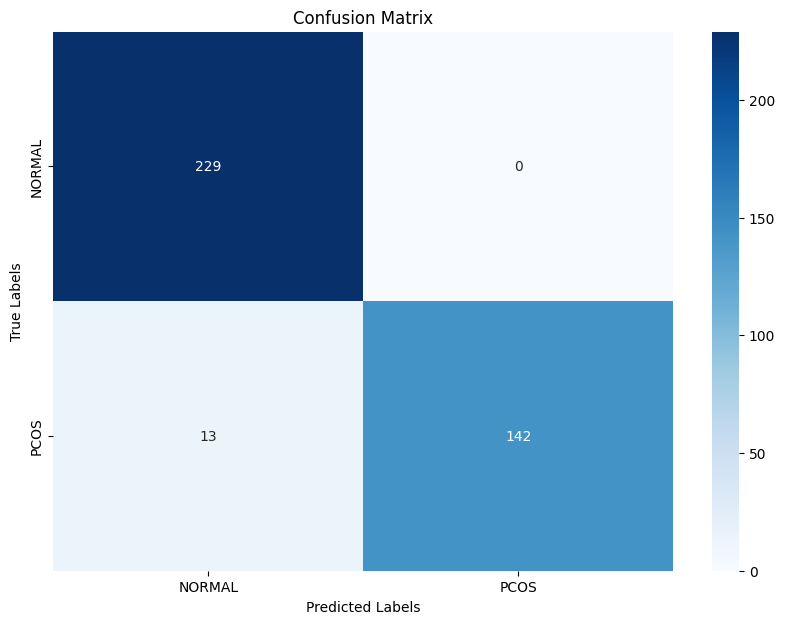

In [ ]:
import seaborn as sns

#confusion matrix as heatmap
def plot_confusion_matrix(conf_matrix, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(conf_matrix_nasnet_mobile, le.classes_)


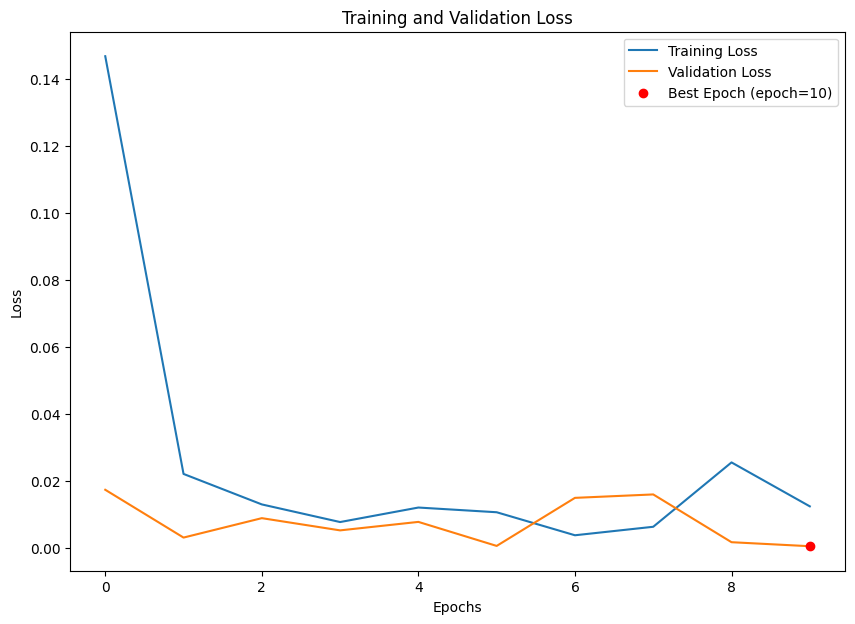

In [ ]:
#training/validation loss curve with the best epoch marked
def plot_loss_curve_with_best_epoch(history, title='Training and Validation Loss'):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    best_epoch = np.argmin(val_loss)
    best_val_loss = val_loss[best_epoch]

    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.scatter(best_epoch, best_val_loss, color='red', label=f'Best Epoch (epoch={best_epoch+1})', zorder=5)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss_curve_with_best_epoch(history_nasnet_mobile)


12/12 [==============================] - 2s 162ms/step


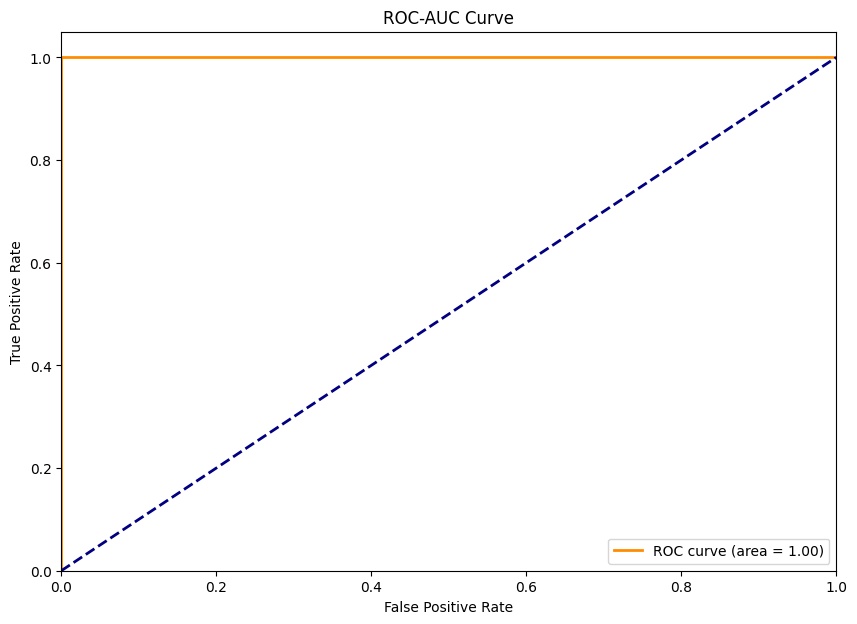

In [ ]:
from sklearn.metrics import roc_curve, auc

#ROC-AUC curve
def plot_roc_auc_curve(model, test_generator, encoded_test_labels, title='ROC-AUC Curve'):
    y_true = encoded_test_labels[:len(test_predictions_nasnet_mobile)]
    y_pred_proba = model.predict(test_generator, steps=len(normalized_test_images) // 32)

    if y_pred_proba.shape[1] == 2:
        y_pred_proba = y_pred_proba[:, 1]

    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

plot_roc_auc_curve(model_nasnet_mobile, test_generator, encoded_test_labels)


**resnet-152**

In [ ]:
from tensorflow.keras.applications import ResNet152
base_model_resnet152 = ResNet152(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

for layer in base_model_resnet152.layers:
    layer.trainable = False

x = base_model_resnet152.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(le.classes_), activation='softmax')(x)

model_resnet152 = Model(inputs=base_model_resnet152.input, outputs=predictions)
model_resnet152.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_resnet152.summary()

234698864/234698864 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                     

In [ ]:
history_resnet152 = model_resnet152.fit(
    train_generator,
    steps_per_epoch=len(normalized_train_images) // 32,
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(normalized_val_images) // 32
)

Epoch 1/10
188/188 [==============================] - 219s 1s/step - loss: 0.1899 - accuracy: 0.9245 - val_loss: 0.3059 - val_accuracy: 0.8403
Epoch 2/10
188/188 [==============================] - 213s 1s/step - loss: 0.0560 - accuracy: 0.9818 - val_loss: 0.2339 - val_accuracy: 0.8715
Epoch 3/10
188/188 [==============================] - 212s 1s/step - loss: 0.0425 - accuracy: 0.9873 - val_loss: 0.0222 - val_accuracy: 0.9931
Epoch 4/10
188/188 [==============================] - 205s 1s/step - loss: 0.0255 - accuracy: 0.9917 - val_loss: 0.0137 - val_accuracy: 0.9965
Epoch 5/10
188/188 [==============================] - 214s 1s/step - loss: 0.0192 - accuracy: 0.9948 - val_loss: 0.0159 - val_accuracy: 0.9965
Epoch 6/10
188/188 [==============================] - 208s 1s/step - loss: 0.0148 - accuracy: 0.9960 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 7/10
188/188 [==============================] - 212s 1s/step - loss: 0.0219 - accuracy: 0.9927 - val_loss: 0.0738 - val_accuracy: 0.9688

In [ ]:
test_loss_resnet152, test_accuracy_resnet152 = model_resnet152.evaluate(test_generator, steps=len(normalized_test_images) // 32)
print("Test Loss for ResNet152:", test_loss_resnet152)
print("Test Accuracy for ResNet152:", test_accuracy_resnet152)

from sklearn.metrics import confusion_matrix, classification_report

test_predictions_resnet152 = model_resnet152.predict(test_generator, steps=len(normalized_test_images) // 32)
test_predictions_resnet152 = np.argmax(test_predictions_resnet152, axis=1)

conf_matrix_resnet152 = confusion_matrix(encoded_test_labels[:len(test_predictions_resnet152)], test_predictions_resnet152)
print("Confusion Matrix for ResNet152:")
print(conf_matrix_resnet152)

print("Generating Classification Report for ResNet152...")
class_report_resnet152 = classification_report(encoded_test_labels[:len(test_predictions_resnet152)], test_predictions_resnet152, target_names=le.classes_)
print("Classification Report for ResNet152:")
print(class_report_resnet152)
print("Classification Report Generated Successfully.")

12/12 [==============================] - 13s 1s/step - loss: 0.1532 - accuracy: 0.9583
Test Loss for ResNet152: 0.15322642028331757
Test Accuracy for ResNet152: 0.9583333134651184
12/12 [==============================] - 16s 1s/step
Confusion Matrix for ResNet152:
[[229   0]
 [ 16 139]]
Generating Classification Report for ResNet152...
Classification Report for ResNet152:
              precision    recall  f1-score   support

      NORMAL       0.93      1.00      0.97       229
        PCOS       1.00      0.90      0.95       155

    accuracy                           0.96       384
   macro avg       0.97      0.95      0.96       384
weighted avg       0.96      0.96      0.96       384

Classification Report Generated Successfully.


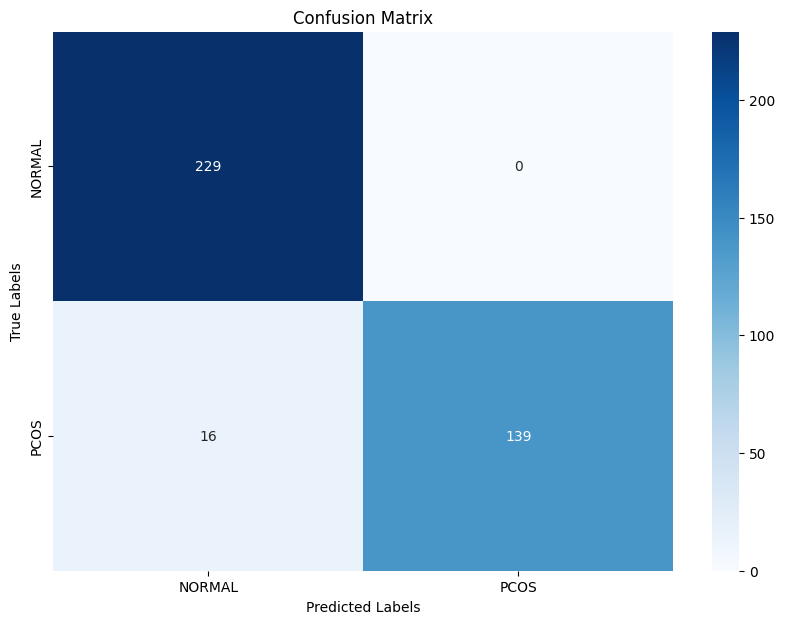

In [ ]:
import seaborn as sns

def plot_confusion_matrix(conf_matrix, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(conf_matrix_resnet152, le.classes_)


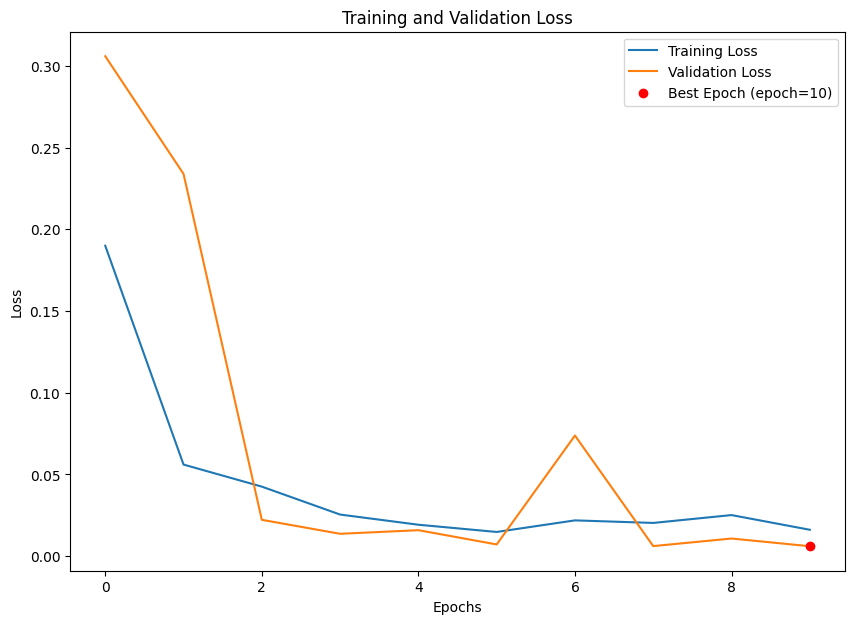

In [ ]:
def plot_loss_curve_with_best_epoch(history, title='Training and Validation Loss'):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    best_epoch = np.argmin(val_loss)
    best_val_loss = val_loss[best_epoch]

    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.scatter(best_epoch, best_val_loss, color='red', label=f'Best Epoch (epoch={best_epoch+1})', zorder=5)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss_curve_with_best_epoch(history_resnet152)


12/12 [==============================] - 12s 1s/step


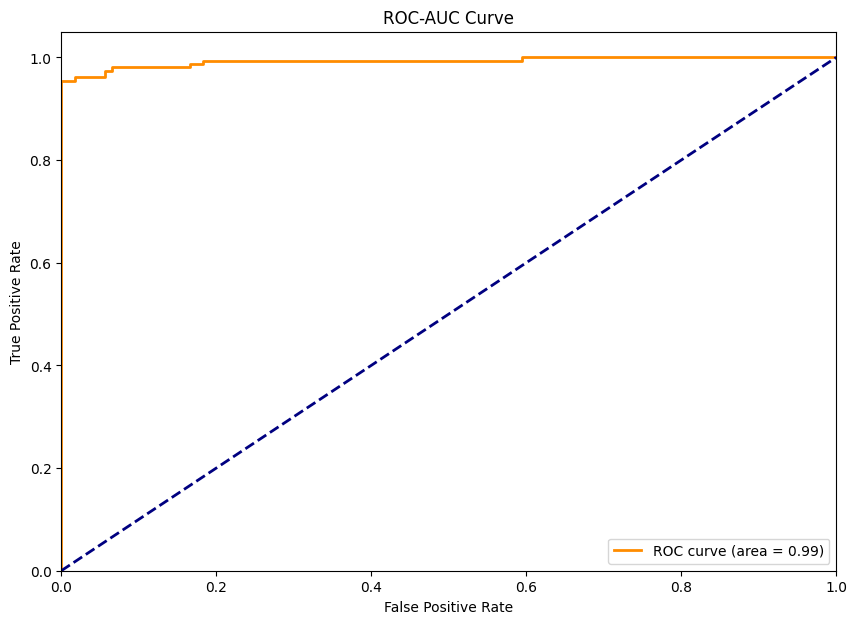

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_auc_curve(model, test_generator, encoded_test_labels, title='ROC-AUC Curve'):
    y_true = encoded_test_labels[:len(test_predictions_resnet152)]
    y_pred_proba = model.predict(test_generator, steps=len(normalized_test_images) // 32)


    if y_pred_proba.shape[1] == 2:
        y_pred_proba = y_pred_proba[:, 1]

    fpr, tpr, _ = roc_curve(y_true, y_pred_proba, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

plot_roc_auc_curve(model_resnet152, test_generator, encoded_test_labels)


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report


conf_matrix_resnet152 = confusion_matrix(encoded_test_labels[:len(test_predictions_resnet152)], test_predictions_resnet152)

tn, fp, fn, tp = conf_matrix_resnet152.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity (Recall or True Positive Rate) for ResNet152:", sensitivity)
print("Specificity (True Negative Rate) for ResNet152:", specificity)


Sensitivity (Recall or True Positive Rate) for ResNet152: 0.896774193548387
Specificity (True Negative Rate) for ResNet152: 1.0


**Xception**

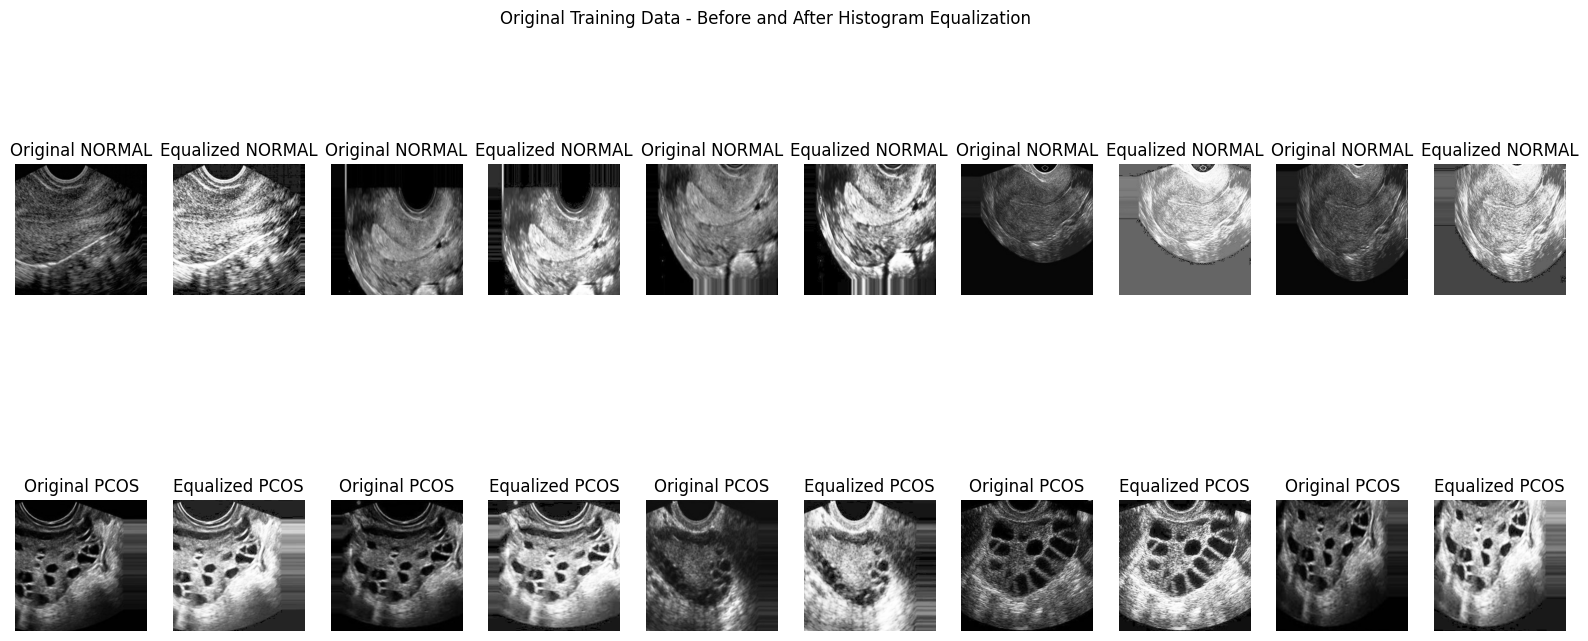

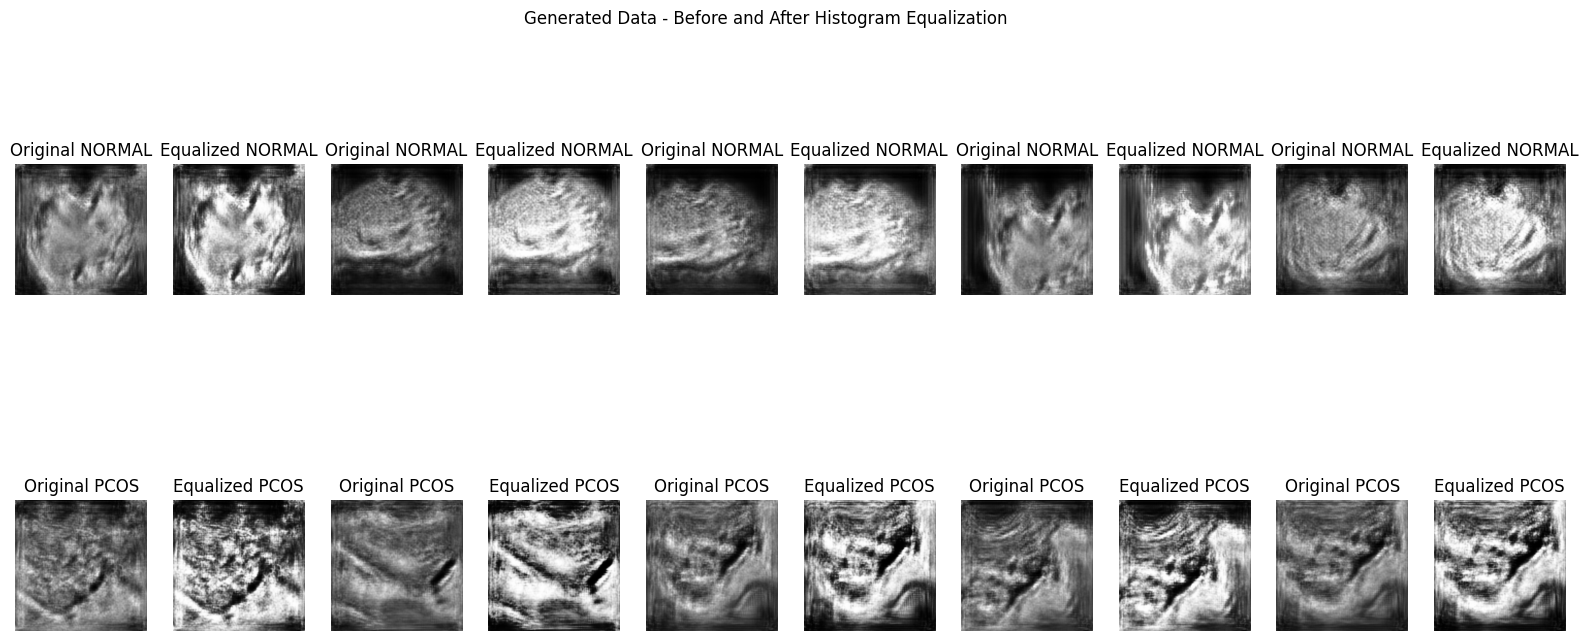

In [ ]:
#resizing 299, 299
def load_data_xception(directory, target_size=(299, 299)):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = Image.open(image_path).convert('L')
            image = image.resize(target_size)
            image = np.stack((image,)*3, axis=-1)
            images.append(np.array(image))
            labels.append(class_name)
    return np.array(images), np.array(labels)

def apply_histogram_equalization_xception(image):
    image_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    image_yuv[:,:,0] = cv2.equalizeHist(image_yuv[:,:,0])
    image_equalized = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
    return image_equalized

def visualize_histogram_equalization_xception(images, labels, title):
    classes = np.unique(labels)
    fig, axes = plt.subplots(len(classes), 10, figsize=(20, len(classes)*4))
    fig.suptitle(title)

    for i, class_name in enumerate(classes):
        class_images = images[labels == class_name][:5]
        for j, image in enumerate(class_images):
            axes[i, j*2].imshow(image)
            axes[i, j*2].set_title(f"Original {class_name}")
            axes[i, j*2].axis('off')

            equalized_image = apply_histogram_equalization_xception(image)
            axes[i, j*2 + 1].imshow(equalized_image)
            axes[i, j*2 + 1].set_title(f"Equalized {class_name}")
            axes[i, j*2 + 1].axis('off')

    plt.show()

train_dir_xception = '/content/drive/MyDrive/Dataset/Train'
test_dir_xception = '/content/drive/MyDrive/Dataset/Test'
train_images_xception, train_labels_xception = load_data_xception(train_dir_xception)
test_images_xception, test_labels_xception = load_data_xception(test_dir_xception)


generated_data_dir_xception = '/content/drive/MyDrive/AllGenerated'
generated_images_xception, generated_labels_xception = load_data_xception(generated_data_dir_xception)

visualize_histogram_equalization_xception(train_images_xception, train_labels_xception, "Original Training Data - Before and After Histogram Equalization")

visualize_histogram_equalization_xception(generated_images_xception, generated_labels_xception, "Generated Data - Before and After Histogram Equalization")
equalized_train_images_xception = np.array([apply_histogram_equalization_xception(image) for image in train_images_xception])
equalized_test_images_xception = np.array([apply_histogram_equalization_xception(image) for image in test_images_xception])
equalized_generated_images_xception = np.array([apply_histogram_equalization_xception(image) for image in generated_images_xception])


In [ ]:
from sklearn.model_selection import train_test_split

original_train_images_xception, original_val_images_xception, original_train_labels_xception, original_val_labels_xception = train_test_split(
    equalized_train_images_xception, train_labels_xception, test_size=0.2, random_state=42
)

combined_train_images_xception = np.concatenate((original_train_images_xception, equalized_generated_images_xception), axis=0)
combined_train_labels_xception = np.concatenate((original_train_labels_xception, generated_labels_xception), axis=0)

def normalize_images_xception(image_list):
    normalized_images = []
    for image in image_list:
        normalized_image = image.astype('float32') / 255.0
        normalized_images.append(normalized_image)
    return np.array(normalized_images)

normalized_train_images_xception = normalize_images_xception(combined_train_images_xception)
normalized_val_images_xception = normalize_images_xception(original_val_images_xception)
normalized_test_images_xception = normalize_images_xception(equalized_test_images_xception)

le_xception = LabelEncoder()
encoded_train_labels_xception = le_xception.fit_transform(combined_train_labels_xception)
encoded_val_labels_xception = le_xception.transform(original_val_labels_xception)
encoded_test_labels_xception = le_xception.transform(test_labels_xception)

train_datagen_xception = ImageDataGenerator()
val_datagen_xception = ImageDataGenerator()
test_datagen_xception = ImageDataGenerator()

train_generator_xception = train_datagen_xception.flow(normalized_train_images_xception, encoded_train_labels_xception, batch_size=32)
val_generator_xception = val_datagen_xception.flow(normalized_val_images_xception, encoded_val_labels_xception, batch_size=32, shuffle=False)
test_generator_xception = test_datagen_xception.flow(normalized_test_images_xception, encoded_test_labels_xception, batch_size=32, shuffle=False)


In [ ]:
from tensorflow.keras.applications import Xception


base_model_xception = Xception(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))

for layer in base_model_xception.layers:
    layer.trainable = False

x_xception = base_model_xception.output
x_xception = GlobalAveragePooling2D()(x_xception)
x_xception = Dense(512, activation='relu')(x_xception)
x_xception = Dropout(0.5)(x_xception)
predictions_xception = Dense(len(le_xception.classes_), activation='softmax')(x_xception)

model_xception = Model(inputs=base_model_xception.input, outputs=predictions_xception)
model_xception.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_xception.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_3[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati

In [ ]:

history_xception = model_xception.fit(
    train_generator_xception,
    steps_per_epoch=len(normalized_train_images_xception) // 32,
    epochs=10,
    validation_data=val_generator_xception,
    validation_steps=len(normalized_val_images_xception) // 32
)


Epoch 1/10
188/188 [==============================] - 180s 942ms/step - loss: 0.0943 - accuracy: 0.9650 - val_loss: 1.3601e-04 - val_accuracy: 1.0000
Epoch 2/10
188/188 [==============================] - 177s 942ms/step - loss: 0.0146 - accuracy: 0.9957 - val_loss: 4.1230e-04 - val_accuracy: 1.0000
Epoch 3/10
188/188 [==============================] - 180s 956ms/step - loss: 0.0099 - accuracy: 0.9970 - val_loss: 3.9436e-04 - val_accuracy: 1.0000
Epoch 4/10
188/188 [==============================] - 167s 890ms/step - loss: 0.0054 - accuracy: 0.9983 - val_loss: 1.7451e-05 - val_accuracy: 1.0000
Epoch 5/10
188/188 [==============================] - 166s 885ms/step - loss: 0.0091 - accuracy: 0.9968 - val_loss: 1.3231e-05 - val_accuracy: 1.0000
Epoch 6/10
188/188 [==============================] - 171s 911ms/step - loss: 0.0038 - accuracy: 0.9988 - val_loss: 1.7416e-05 - val_accuracy: 1.0000
Epoch 7/10
188/188 [==============================] - 169s 897ms/step - loss: 0.0020 - accuracy: 0.9

In [ ]:
test_loss_xception, test_accuracy_xception = model_xception.evaluate(test_generator_xception, steps=len(normalized_test_images_xception) // 32)
print("Test Loss for Xception:", test_loss_xception)
print("Test Accuracy for Xception:", test_accuracy_xception)

from sklearn.metrics import confusion_matrix, classification_report

test_predictions_xception = model_xception.predict(test_generator_xception, steps=len(normalized_test_images_xception) // 32)
test_predictions_xception = np.argmax(test_predictions_xception, axis=1)

conf_matrix_xception = confusion_matrix(encoded_test_labels_xception[:len(test_predictions_xception)], test_predictions_xception)
print("Confusion Matrix for Xception:")
print(conf_matrix_xception)

print("Generating Classification Report for Xception...")
class_report_xception = classification_report(encoded_test_labels_xception[:len(test_predictions_xception)], test_predictions_xception, target_names=le_xception.classes_)
print("Classification Report for Xception:")
print(class_report_xception)
print("Classification Report Generated Successfully.")

12/12 [==============================] - 10s 826ms/step - loss: 0.1026 - accuracy: 0.9792
Test Loss for Xception: 0.102630615234375
Test Accuracy for Xception: 0.9791666865348816
12/12 [==============================] - 11s 861ms/step
Confusion Matrix for Xception:
[[229   0]
 [  8 147]]
Generating Classification Report for Xception...
Classification Report for Xception:
              precision    recall  f1-score   support

      NORMAL       0.97      1.00      0.98       229
        PCOS       1.00      0.95      0.97       155

    accuracy                           0.98       384
   macro avg       0.98      0.97      0.98       384
weighted avg       0.98      0.98      0.98       384

Classification Report Generated Successfully.


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report


conf_matrix_xception = confusion_matrix(encoded_test_labels_xception[:len(test_predictions_xception)], test_predictions_xception)

print("Confusion Matrix for Xception:")
print(conf_matrix_xception)
tn, fp, fn, tp = conf_matrix_xception.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity (Recall or True Positive Rate) for Xception:", sensitivity)
print("Specificity (True Negative Rate) for Xception:", specificity)


Confusion Matrix for Xception:
[[229   0]
 [  8 147]]
Sensitivity (Recall or True Positive Rate) for Xception: 0.9483870967741935
Specificity (True Negative Rate) for Xception: 1.0


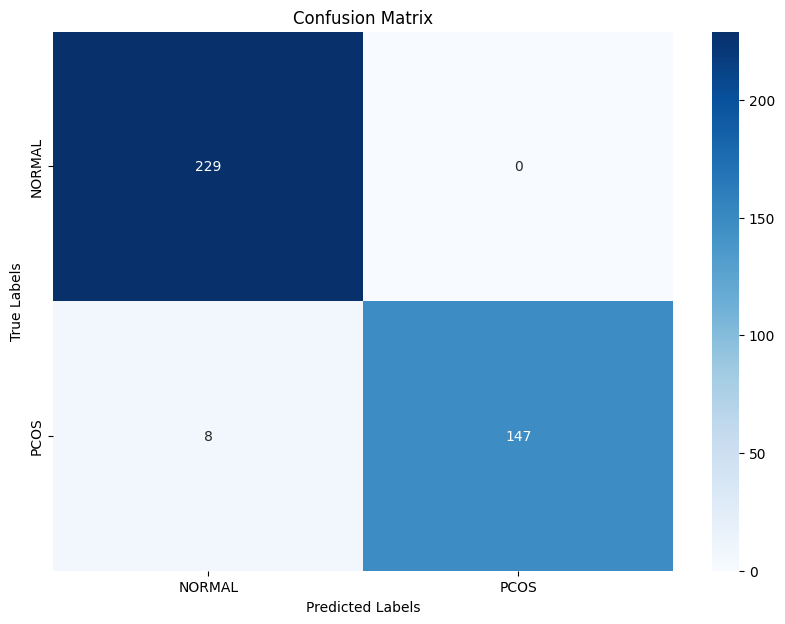

In [ ]:
import seaborn as sns

def plot_confusion_matrix_xception(conf_matrix, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix_xception(conf_matrix_xception, le_xception.classes_)

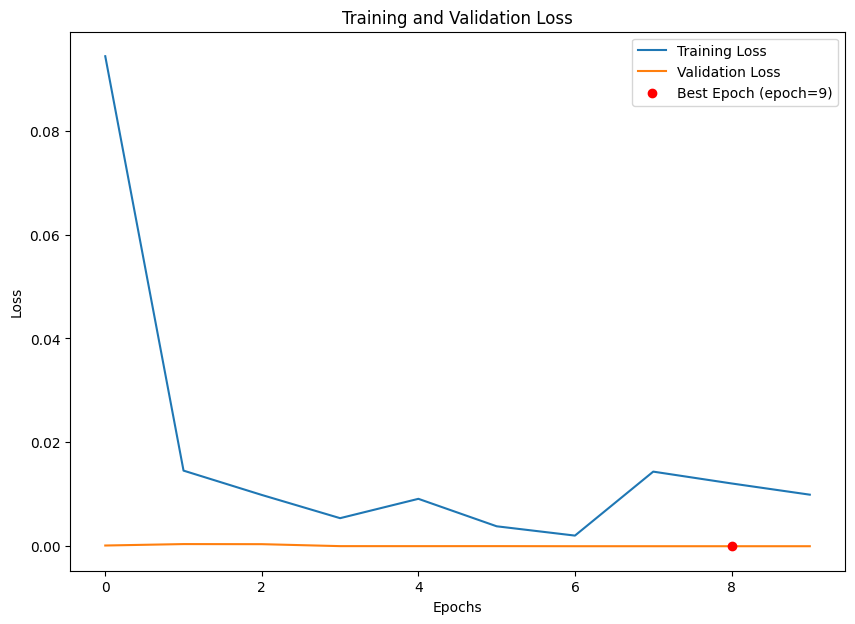

In [ ]:
def plot_loss_curve_with_best_epoch(history, title='Training and Validation Loss'):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    best_epoch = np.argmin(val_loss)
    best_val_loss = val_loss[best_epoch]

    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.scatter(best_epoch, best_val_loss, color='red', label=f'Best Epoch (epoch={best_epoch+1})', zorder=5)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss_curve_with_best_epoch(history_xception)

12/12 [==============================] - 11s 889ms/step


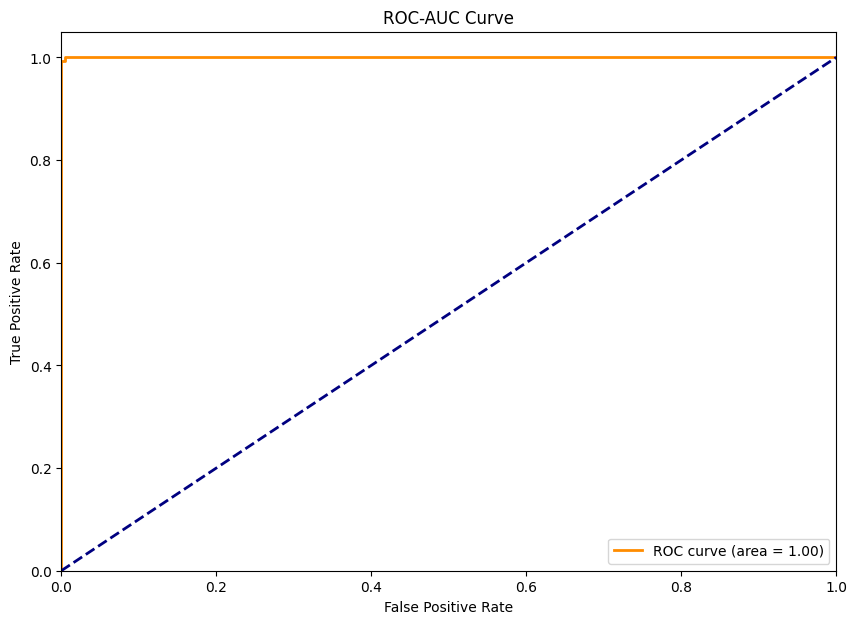

In [ ]:
def plot_roc_auc_curve(model, test_generator, encoded_test_labels, title='ROC-AUC Curve'):
    y_true = encoded_test_labels[:len(test_predictions_xception)]
    y_pred_proba = model.predict(test_generator, steps=len(normalized_test_images_xception) // 32)

    if y_pred_proba.shape[1] == 2:
        y_pred_proba = y_pred_proba[:, 1]

    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

plot_roc_auc_curve(model_xception, test_generator_xception, encoded_test_labels_xception)


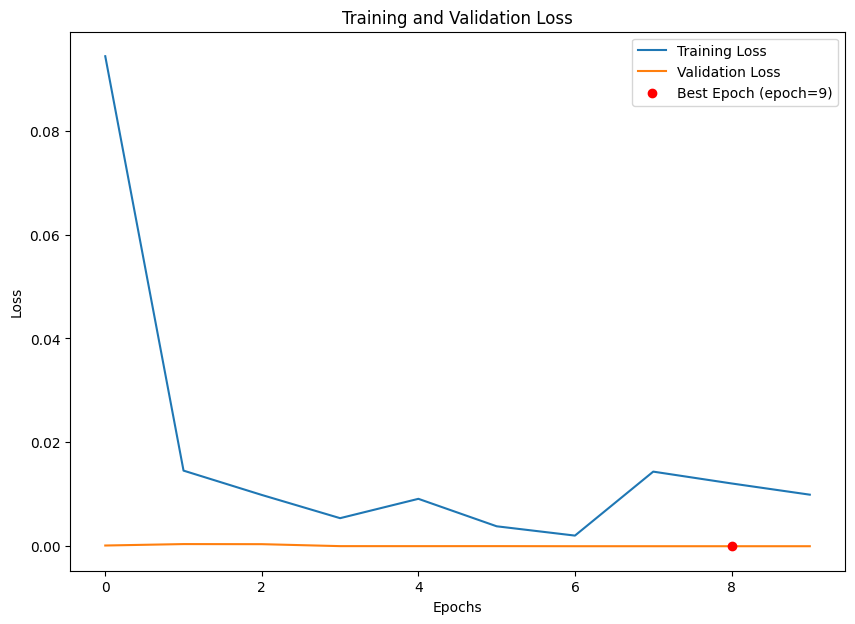

In [ ]:

def plot_loss_curve_with_best_epoch(history, title='Training and Validation Loss'):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    best_epoch = np.argmin(val_loss)
    best_val_loss = val_loss[best_epoch]

    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.scatter(best_epoch, best_val_loss, color='red', label=f'Best Epoch (epoch={best_epoch+1})', zorder=5)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss_curve_with_best_epoch(history_xception)

**hybrid models**

**xception + catboost**

In [ ]:
#Xception model for feature extraction
hybrid_model_xception = Xception(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))

for layer in hybrid_model_xception.layers:
    layer.trainable = False

feature_extractor_xception = Model(inputs=hybrid_model_xception.input, outputs=hybrid_model_xception.output)

train_features_xception = feature_extractor_xception.predict(normalized_train_images_xception, batch_size=32)
train_features_xception = train_features_xception.reshape(train_features_xception.shape[0], -1)

val_features_xception = feature_extractor_xception.predict(normalized_val_images_xception, batch_size=32)
val_features_xception = val_features_xception.reshape(val_features_xception.shape[0], -1)

test_features_xception = feature_extractor_xception.predict(normalized_test_images_xception, batch_size=32)
test_features_xception = test_features_xception.reshape(test_features_xception.shape[0], -1)


13/13 [==============================] - 11s 831ms/step


In [ ]:
!pip install CatBoost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

catboost_classifier = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=4, verbose=10)
catboost_classifier.fit(train_features_xception, encoded_train_labels_xception, eval_set=(val_features_xception, encoded_val_labels_xception))

catboost_probabilities_xception = catboost_classifier.predict_proba(test_features_xception)[:, 1]

catboost_predictions_xception = catboost_classifier.predict(test_features_xception)


catboost_accuracy_xception = accuracy_score(encoded_test_labels_xception, catboost_predictions_xception)
print(f"CatBoost Accuracy: {catboost_accuracy_xception}")

catboost_confusion_matrix_xception = confusion_matrix(encoded_test_labels_xception, catboost_predictions_xception)
print("Confusion Matrix for CatBoost:")
print(catboost_confusion_matrix_xception)

catboost_classification_report_xception = classification_report(encoded_test_labels_xception, catboost_predictions_xception, target_names=le_xception.classes_)
print("Classification Report for CatBoost:")
print(catboost_classification_report_xception)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.0 MB/s eta 0:00:00
0:	learn: 0.5825123	test: 0.6150877	best: 0.6150877 (0)	total: 3.03s	remaining: 4m 59s
10:	learn: 0.1657958	test: 0.1941491	best: 0.1941491 (10)	total: 32.2s	remaining: 4m 20s
20:	learn: 0.0821718	test: 0.0962529	best: 0.0962529 (20)	total: 1m 1s	remaining: 3m 51s
30:	learn: 0.0481602	test: 0.0540067	best: 0.0540067 (30)	total: 1m 30s	remaining: 3m 21s
40:	learn: 0.0303171	test: 0.0374527	best: 0.0374527 (40)	total: 1m 59s	remaining: 2m 51s
50:	learn: 0.0206818	test: 0.0268014	best: 0.0268014 (50)	total: 2m 28s	remaining: 2m 22s
60:	learn: 0.0142319	test: 0.0206021	best: 0.0204373 (59)	total: 2m 57s	remaining: 1m 53s
70:	learn: 0.0109319	test: 0.0173156	best: 0.0172519 (68)	total: 3m 26s	remaining: 1m 24s
80:	learn: 0.0091946	test: 0.0159071	best: 0.0159071 (80)	total: 3m 55s	remaining: 55.3s
90:	learn: 0.0074042	test: 0.0126498	be

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report


catboost_confusion_matrix_xception = confusion_matrix(encoded_test_labels_xception, catboost_predictions_xception)

print("Confusion Matrix for CatBoost:")
print(catboost_confusion_matrix_xception)

tn, fp, fn, tp = catboost_confusion_matrix_xception.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity (Recall or True Positive Rate) for XceptionNet + Catboost:", sensitivity)
print("Specificity (True Negative Rate) for XceptionNet + Catboost:", specificity)


Confusion Matrix for CatBoost:
[[229   0]
 [  6 163]]
Sensitivity (Recall or True Positive Rate) for XceptionNet + Catboost: 0.9644970414201184
Specificity (True Negative Rate) for XceptionNet + Catboost: 1.0


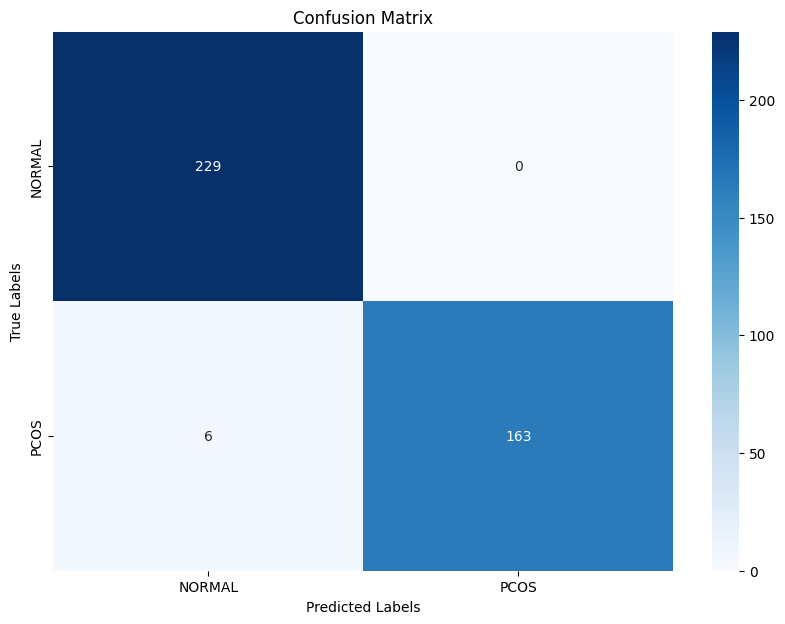

In [ ]:
def plot_confusion_matrix_xception(conf_matrix, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix_xception(catboost_confusion_matrix_xception, le_xception.classes_)

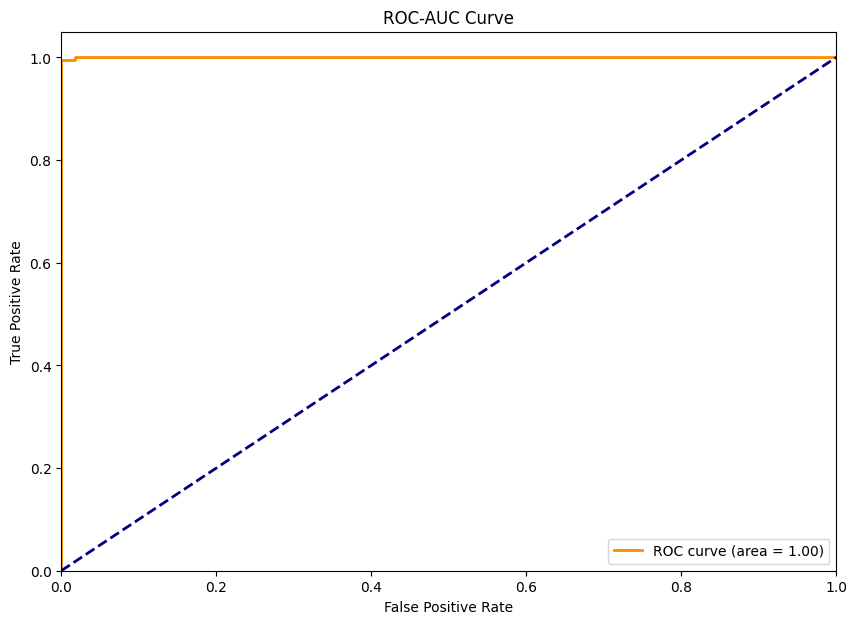

In [ ]:
def plot_roc_auc_curve_xception(encoded_labels, predictions, title='ROC-AUC Curve'):
    fpr, tpr, _ = roc_curve(encoded_labels, predictions, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

plot_roc_auc_curve_xception(encoded_test_labels_xception, catboost_probabilities_xception)

**resnet152 + catboost**

In [ ]:
#ResNet152 model for feature extraction
hybrid_model_resnet152 = ResNet152(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

for layer in hybrid_model_resnet152.layers:
    layer.trainable = False

feature_extractor_resnet152 = Model(inputs=hybrid_model_resnet152.input, outputs=hybrid_model_resnet152.output)


train_features_resnet152 = feature_extractor_resnet152.predict(normalized_train_images, batch_size=32)
train_features_resnet152 = train_features_resnet152.reshape(train_features_resnet152.shape[0], -1)

val_features_resnet152 = feature_extractor_resnet152.predict(normalized_val_images, batch_size=32)
val_features_resnet152 = val_features_resnet152.reshape(val_features_resnet152.shape[0], -1)

test_features_resnet152 = feature_extractor_resnet152.predict(normalized_test_images, batch_size=32)
test_features_resnet152 = test_features_resnet152.reshape(test_features_resnet152.shape[0], -1)


13/13 [==============================] - 13s 1s/step


In [ ]:

catboost_classifier.fit(train_features_resnet152, encoded_train_labels, eval_set=(val_features_resnet152, encoded_val_labels))

catboost_probabilities_resnet = catboost_classifier.predict_proba(test_features_resnet152)[:, 1]

catboost_predictions_resnet = catboost_classifier.predict(test_features_resnet152)

catboost_accuracy_resnet = accuracy_score(encoded_test_labels, catboost_predictions_resnet)
print(f"CatBoost Accuracy (ResNet152): {catboost_accuracy_resnet}")

catboost_confusion_matrix_resnet = confusion_matrix(encoded_test_labels, catboost_predictions_resnet)
print("Confusion Matrix for CatBoost (ResNet152):")
print(catboost_confusion_matrix_resnet)

catboost_classification_report_resnet = classification_report(encoded_test_labels, catboost_predictions_resnet, target_names=le.classes_)
print("Classification Report for CatBoost (ResNet152):")
print(catboost_classification_report_resnet)

0:	learn: 0.5147305	test: 0.5395014	best: 0.5395014 (0)	total: 135ms	remaining: 13.4s
10:	learn: 0.0563956	test: 0.0990036	best: 0.0990036 (10)	total: 1.43s	remaining: 11.5s
20:	learn: 0.0212558	test: 0.0448185	best: 0.0448185 (20)	total: 2.71s	remaining: 10.2s
30:	learn: 0.0128519	test: 0.0303845	best: 0.0303845 (30)	total: 3.98s	remaining: 8.86s
40:	learn: 0.0089255	test: 0.0226259	best: 0.0226259 (40)	total: 5.26s	remaining: 7.57s
50:	learn: 0.0058349	test: 0.0155819	best: 0.0155819 (50)	total: 6.55s	remaining: 6.29s
60:	learn: 0.0040686	test: 0.0115472	best: 0.0115472 (60)	total: 7.84s	remaining: 5.01s
70:	learn: 0.0032941	test: 0.0095927	best: 0.0095926 (68)	total: 9.14s	remaining: 3.73s
80:	learn: 0.0030158	test: 0.0088571	best: 0.0088567 (75)	total: 10.4s	remaining: 2.45s
90:	learn: 0.0027203	test: 0.0078476	best: 0.0078475 (87)	total: 11.7s	remaining: 1.16s
99:	learn: 0.0027202	test: 0.0078480	best: 0.0078475 (87)	total: 12.9s	remaining: 0us

bestTest = 0.00784747985
bestIterat

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report


catboost_confusion_matrix_resnet = confusion_matrix(encoded_test_labels, catboost_predictions_resnet)

print("Confusion Matrix for CatBoost (ResNet152):")
print(catboost_confusion_matrix_resnet)

tn, fp, fn, tp = catboost_confusion_matrix_resnet.ravel()


sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity (Recall or True Positive Rate) for ResNet152 + Catboost:", sensitivity)
print("Specificity (True Negative Rate) for CatBoost ResNet152 + Catboost:", specificity)


Confusion Matrix for CatBoost (ResNet152):
[[229   0]
 [ 23 146]]
Sensitivity (Recall or True Positive Rate) for ResNet152 + Catboost: 0.863905325443787
Specificity (True Negative Rate) for CatBoost ResNet152 + Catboost: 1.0


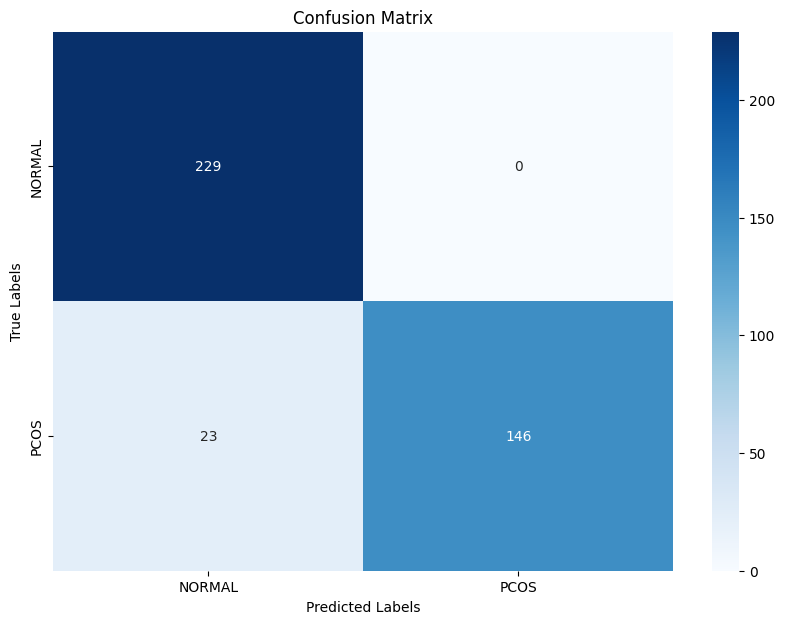

In [ ]:
def plot_confusion_matrix(conf_matrix, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(catboost_confusion_matrix_resnet, le.classes_)

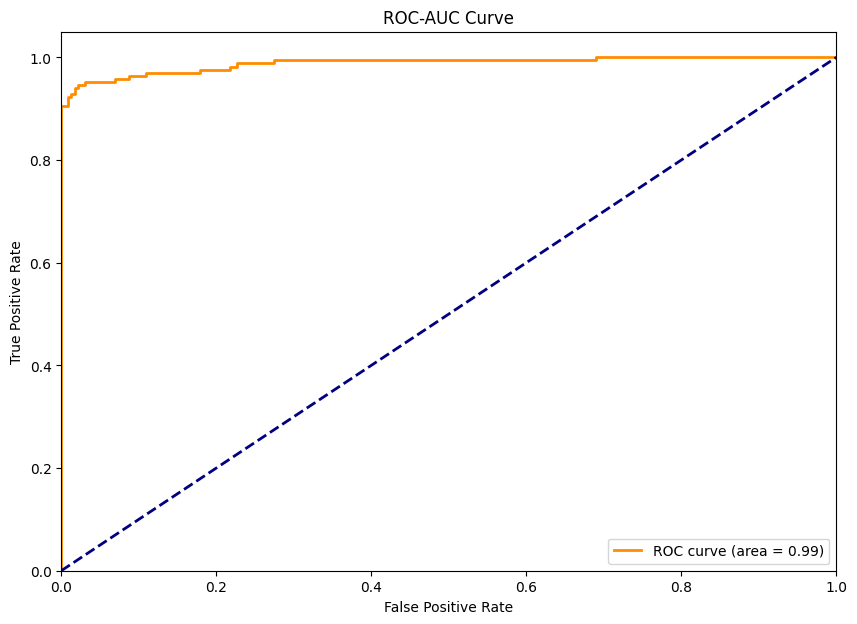

In [ ]:
def plot_roc_auc_curve(encoded_labels, predictions, title='ROC-AUC Curve'):
    fpr, tpr, _ = roc_curve(encoded_labels, predictions, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

plot_roc_auc_curve(encoded_test_labels, catboost_probabilities_resnet)

**NasNetMobile + catboost**

In [ ]:
from tensorflow.keras.applications import NASNetMobile
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


hybrid_model_nasnet_mobile = NASNetMobile(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

for layer in hybrid_model_nasnet_mobile.layers:
    layer.trainable = False

#NasNetMobile model for feature extraction
feature_extractor_nasnet_mobile = Model(inputs=hybrid_model_nasnet_mobile.input, outputs=hybrid_model_nasnet_mobile.output)


train_features_nasnet_mobile = feature_extractor_nasnet_mobile.predict(normalized_train_images, batch_size=32)
train_features_nasnet_mobile = train_features_nasnet_mobile.reshape(train_features_nasnet_mobile.shape[0], -1)

val_features_nasnet_mobile = feature_extractor_nasnet_mobile.predict(normalized_val_images, batch_size=32)
val_features_nasnet_mobile = val_features_nasnet_mobile.reshape(val_features_nasnet_mobile.shape[0], -1)

test_features_nasnet_mobile = feature_extractor_nasnet_mobile.predict(normalized_test_images, batch_size=32)
test_features_nasnet_mobile = test_features_nasnet_mobile.reshape(test_features_nasnet_mobile.shape[0], -1)


13/13 [==============================] - 2s 147ms/step


In [ ]:
!pip install catboost

from catboost import CatBoostClassifier

catboost_classifier = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=4, verbose=10)
catboost_classifier.fit(train_features_nasnet_mobile, encoded_train_labels, eval_set=(val_features_nasnet_mobile, encoded_val_labels))

#predicting probabilities using the CatBoost classifier
catboost_probabilities = catboost_classifier.predict_proba(test_features_nasnet_mobile)[:, 1]

catboost_predictions = catboost_classifier.predict(test_features_nasnet_mobile)

catboost_accuracy = accuracy_score(encoded_test_labels, catboost_predictions)
print(f"CatBoost Accuracy: {catboost_accuracy}")

catboost_confusion_matrix = confusion_matrix(encoded_test_labels, catboost_predictions)
print("Confusion Matrix for CatBoost:")
print(catboost_confusion_matrix)

catboost_classification_report = classification_report(encoded_test_labels, catboost_predictions, target_names=le.classes_)
print("Classification Report for CatBoost:")
print(catboost_classification_report)


0:	learn: 0.5816817	test: 0.6058915	best: 0.6058915 (0)	total: 574ms	remaining: 56.9s
10:	learn: 0.1591159	test: 0.2294341	best: 0.2294341 (10)	total: 6.44s	remaining: 52.1s
20:	learn: 0.0718909	test: 0.1136195	best: 0.1136195 (20)	total: 12.2s	remaining: 46s
30:	learn: 0.0398061	test: 0.0654510	best: 0.0654510 (30)	total: 18s	remaining: 40.1s
40:	learn: 0.0242308	test: 0.0402881	best: 0.0402881 (40)	total: 23.9s	remaining: 34.4s
50:	learn: 0.0176831	test: 0.0320197	best: 0.0320197 (50)	total: 29.7s	remaining: 28.6s
60:	learn: 0.0124132	test: 0.0212926	best: 0.0212819 (59)	total: 35.6s	remaining: 22.8s
70:	learn: 0.0093241	test: 0.0166143	best: 0.0166143 (70)	total: 41.5s	remaining: 16.9s
80:	learn: 0.0074142	test: 0.0141207	best: 0.0141148 (79)	total: 47.3s	remaining: 11.1s
90:	learn: 0.0066824	test: 0.0130937	best: 0.0130918 (87)	total: 53.2s	remaining: 5.26s
99:	learn: 0.0051092	test: 0.0102373	best: 0.0102364 (98)	total: 58.5s	remaining: 0us

bestTest = 0.01023641515
bestIteration 

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


catboost_confusion_matrix = confusion_matrix(encoded_test_labels, catboost_predictions)

print("Confusion Matrix for CatBoost:")
print(catboost_confusion_matrix)

tn, fp, fn, tp = catboost_confusion_matrix.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity (Recall or True Positive Rate) for CatBoost:", sensitivity)
print("Specificity (True Negative Rate) for CatBoost:", specificity)


Confusion Matrix for CatBoost:
[[229   0]
 [ 25 144]]
Sensitivity (Recall or True Positive Rate) for CatBoost: 0.8520710059171598
Specificity (True Negative Rate) for CatBoost: 1.0


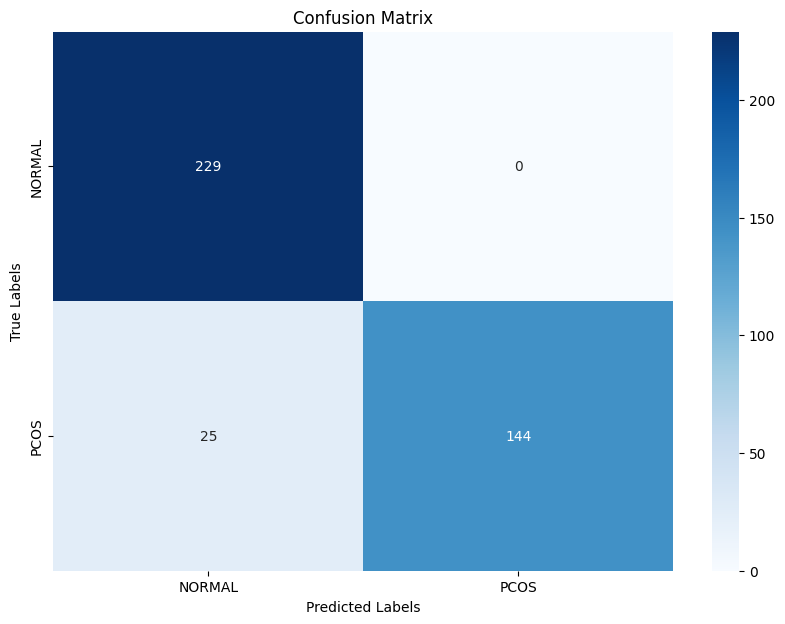

In [ ]:
def plot_confusion_matrix(conf_matrix, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(catboost_confusion_matrix, le.classes_)

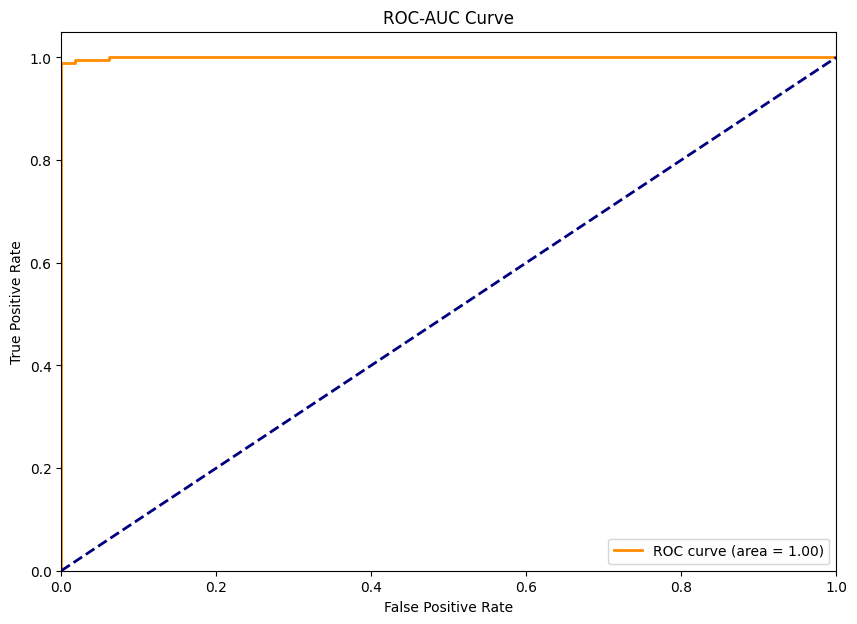

In [ ]:
def plot_roc_auc_curve(encoded_labels, probabilities, title='ROC-AUC Curve'):
    fpr, tpr, _ = roc_curve(encoded_labels, probabilities, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

plot_roc_auc_curve(encoded_test_labels, catboost_probabilities)

**original dataset**

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import NASNetMobile
import tensorflow as tf
import random
from google.colab import drive
import matplotlib.pyplot as plt
import cv2

drive.mount('/content/drive')


seed_value = 9557
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


Mounted at /content/drive


In [ ]:
def load_data(directory, target_size=(224, 224)):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = Image.open(image_path).convert('L')
            image = image.resize(target_size)
            image = np.stack((image,)*3, axis=-1)
            images.append(np.array(image))
            labels.append(class_name)
    return np.array(images), np.array(labels)

train_dir = '/content/drive/MyDrive/Dataset/Train'
test_dir = '/content/drive/MyDrive/Dataset/Test'
train_images, train_labels = load_data(train_dir)
test_images, test_labels = load_data(test_dir)

equalized_train_images = np.array([cv2.equalizeHist(image[:,:,0]) for image in train_images])
equalized_train_images = np.stack((equalized_train_images,)*3, axis=-1)
equalized_test_images = np.array([cv2.equalizeHist(image[:,:,0]) for image in test_images])
equalized_test_images = np.stack((equalized_test_images,)*3, axis=-1)
original_train_images, original_val_images, original_train_labels, original_val_labels = train_test_split(
    equalized_train_images, train_labels, test_size=0.2, random_state=42
)

def normalize_images(image_list):
    normalized_images = []
    for image in image_list:
        normalized_image = image.astype('float32') / 255.0
        normalized_images.append(normalized_image)
    return np.array(normalized_images)

normalized_train_images = normalize_images(original_train_images)
normalized_val_images = normalize_images(original_val_images)
normalized_test_images = normalize_images(equalized_test_images)


In [ ]:
le = LabelEncoder()
encoded_train_labels = le.fit_transform(original_train_labels)
encoded_val_labels = le.transform(original_val_labels)
encoded_test_labels = le.transform(test_labels)

train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(normalized_train_images, encoded_train_labels, batch_size=32)
val_generator = val_datagen.flow(normalized_val_images, encoded_val_labels, batch_size=32, shuffle=False)
test_generator = test_datagen.flow(normalized_test_images, encoded_test_labels, batch_size=32, shuffle=False)

**nasnetmobile**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

base_model_nasnet_mobile = NASNetMobile(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

for layer in base_model_nasnet_mobile.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model_nasnet_mobile.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(le.classes_), activation='softmax')(x)

model_nasnet_mobile = Model(inputs=base_model_nasnet_mobile.input, outputs=predictions)
model_nasnet_mobile.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_nasnet_mobile.summary()


19993432/19993432 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv1 (Conv2D)         (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 stem_bn1 (BatchNormalizati  (None, 111, 111, 32)         128       ['stem_conv1[0][0]']          
 on)                                                                                              
                                                                                                  
 activation (Activation)     

In [ ]:
history_nasnet_mobile = model_nasnet_mobile.fit(
    train_generator,
    steps_per_epoch=len(normalized_train_images) // 32,
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(normalized_val_images) // 32
)

Epoch 1/10
39/39 [==============================] - 26s 342ms/step - loss: 0.1043 - accuracy: 0.9535 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 2/10
39/39 [==============================] - 9s 222ms/step - loss: 0.0071 - accuracy: 0.9992 - val_loss: 5.7509e-04 - val_accuracy: 1.0000
Epoch 3/10
39/39 [==============================] - 9s 229ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.9875e-04 - val_accuracy: 1.0000
Epoch 4/10
39/39 [==============================] - 8s 209ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 1.8747e-04 - val_accuracy: 1.0000
Epoch 5/10
39/39 [==============================] - 9s 218ms/step - loss: 5.4485e-04 - accuracy: 1.0000 - val_loss: 1.5000e-04 - val_accuracy: 1.0000
Epoch 6/10
39/39 [==============================] - 8s 211ms/step - loss: 3.9822e-04 - accuracy: 1.0000 - val_loss: 9.6112e-05 - val_accuracy: 1.0000
Epoch 7/10
39/39 [==============================] - 9s 229ms/step - loss: 4.5158e-04 - accuracy: 1.0000 - val_loss: 7.5

12/12 [==============================] - 2s 169ms/step - loss: 0.0681 - accuracy: 0.9740
Test Loss for NASNetMobile: 0.06812682002782822
Test Accuracy for NASNetMobile: 0.9739583134651184
12/12 [==============================] - 6s 175ms/step
Confusion Matrix for NASNetMobile:
[[229   0]
 [ 10 145]]
Generating Classification Report for NASNetMobile...
Classification Report for NASNetMobile:
              precision    recall  f1-score   support

      NORMAL       0.96      1.00      0.98       229
        PCOS       1.00      0.94      0.97       155

    accuracy                           0.97       384
   macro avg       0.98      0.97      0.97       384
weighted avg       0.98      0.97      0.97       384

Classification Report Generated Successfully.
Sensitivity (Recall or True Positive Rate) for NasNetMobile: 0.9354838709677419
Specificity (True Negative Rate) for NasNetMobile: 1.0


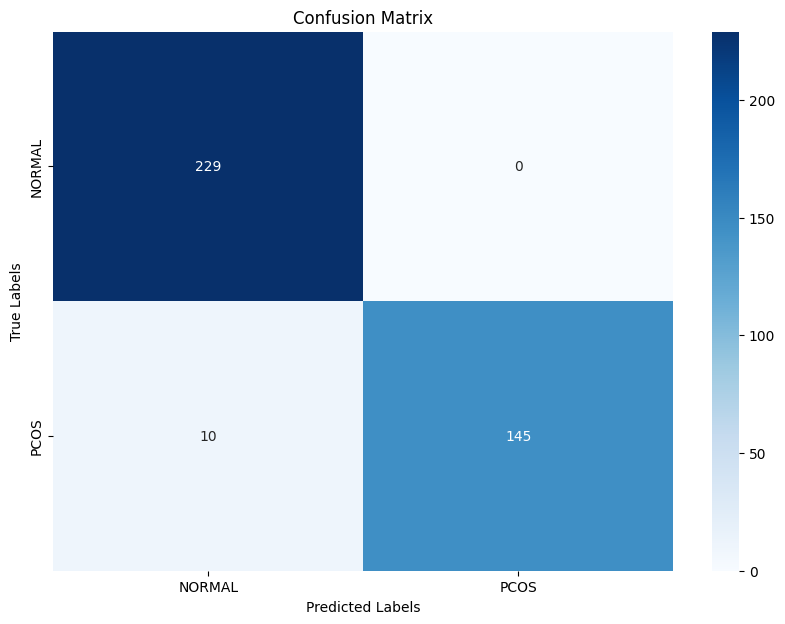

In [ ]:
test_loss_nasnet_mobile, test_accuracy_nasnet_mobile = model_nasnet_mobile.evaluate(test_generator, steps=len(normalized_test_images) // 32)
print("Test Loss for NASNetMobile:", test_loss_nasnet_mobile)
print("Test Accuracy for NASNetMobile:", test_accuracy_nasnet_mobile)

test_predictions_nasnet_mobile = model_nasnet_mobile.predict(test_generator, steps=len(normalized_test_images) // 32)
test_predictions_nasnet_mobile = np.argmax(test_predictions_nasnet_mobile, axis=1)

conf_matrix_nasnet_mobile = confusion_matrix(encoded_test_labels[:len(test_predictions_nasnet_mobile)], test_predictions_nasnet_mobile)
print("Confusion Matrix for NASNetMobile:")
print(conf_matrix_nasnet_mobile)


print("Generating Classification Report for NASNetMobile...")
class_report_nasnet_mobile = classification_report(encoded_test_labels[:len(test_predictions_nasnet_mobile)], test_predictions_nasnet_mobile, target_names=le.classes_)
print("Classification Report for NASNetMobile:")
print(class_report_nasnet_mobile)
print("Classification Report Generated Successfully.")

tn, fp, fn, tp = conf_matrix_nasnet_mobile.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Sensitivity (Recall or True Positive Rate) for NasNetMobile:", sensitivity)
print("Specificity (True Negative Rate) for NasNetMobile:", specificity)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(conf_matrix_nasnet_mobile, le.classes_)

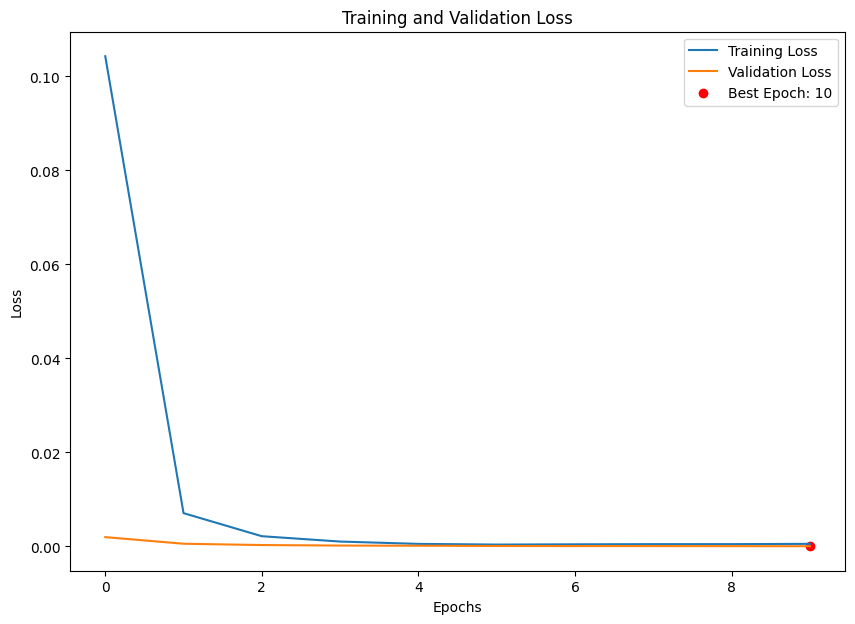

In [ ]:
def plot_loss_curve_with_best_epoch(history, title='Training and Validation Loss'):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    best_epoch = np.argmin(val_loss)
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.scatter(best_epoch, val_loss[best_epoch], color='red', label=f'Best Epoch: {best_epoch+1}')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss_curve_with_best_epoch(history_nasnet_mobile)

12/12 [==============================] - 2s 176ms/step


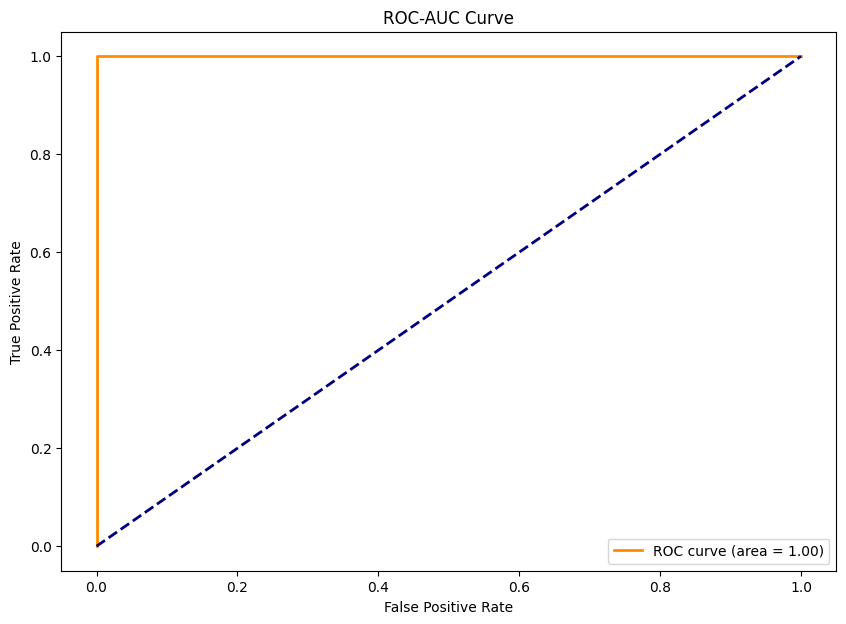

In [ ]:
def plot_roc_auc_curve(model, generator, labels, title='ROC-AUC Curve'):
    y_true = labels[:len(test_predictions_nasnet_mobile)]
    y_pred_proba = model.predict(generator, steps=len(normalized_test_images) // 32)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

plot_roc_auc_curve(model_nasnet_mobile, test_generator, encoded_test_labels)

**resnet152**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

base_model_resnet152 = ResNet152(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

for layer in base_model_resnet152.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model_resnet152.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(le.classes_), activation='softmax')(x)

model_resnet152 = Model(inputs=base_model_resnet152.input, outputs=predictions)
model_resnet152.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_resnet152.summary()

234698864/234698864 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                     

In [ ]:
history_resnet152 = model_resnet152.fit(
    train_generator,
    steps_per_epoch=len(normalized_train_images) // 32,
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(normalized_val_images) // 32
)


Epoch 1/10
39/39 [==============================] - 63s 1s/step - loss: 0.5392 - accuracy: 0.7375 - val_loss: 0.2317 - val_accuracy: 0.8889
Epoch 2/10
39/39 [==============================] - 51s 1s/step - loss: 0.1900 - accuracy: 0.9503 - val_loss: 0.1094 - val_accuracy: 0.9826
Epoch 3/10
39/39 [==============================] - 50s 1s/step - loss: 0.1045 - accuracy: 0.9822 - val_loss: 0.0657 - val_accuracy: 0.9931
Epoch 4/10
39/39 [==============================] - 52s 1s/step - loss: 0.0655 - accuracy: 0.9879 - val_loss: 0.0507 - val_accuracy: 0.9965
Epoch 5/10
39/39 [==============================] - 52s 1s/step - loss: 0.0482 - accuracy: 0.9919 - val_loss: 0.0330 - val_accuracy: 0.9965
Epoch 6/10
39/39 [==============================] - 49s 1s/step - loss: 0.0372 - accuracy: 0.9943 - val_loss: 0.0316 - val_accuracy: 0.9931
Epoch 7/10
39/39 [==============================] - 51s 1s/step - loss: 0.0348 - accuracy: 0.9935 - val_loss: 0.0195 - val_accuracy: 1.0000
Epoch 8/10
39/39 [==

12/12 [==============================] - 13s 1s/step - loss: 0.0765 - accuracy: 0.9714
Test Loss for ResNet152: 0.07647838443517685
Test Accuracy for ResNet152: 0.9713541865348816
12/12 [==============================] - 16s 1s/step
Confusion Matrix for ResNet152:
[[228   1]
 [ 10 145]]
Generating Classification Report for ResNet152...
Classification Report for ResNet152:
              precision    recall  f1-score   support

      NORMAL       0.96      1.00      0.98       229
        PCOS       0.99      0.94      0.96       155

    accuracy                           0.97       384
   macro avg       0.98      0.97      0.97       384
weighted avg       0.97      0.97      0.97       384

Sensitivity (Recall or True Positive Rate) for ResNet152: 0.9354838709677419
Specificity (True Negative Rate) for ResNet152: 0.9956331877729258


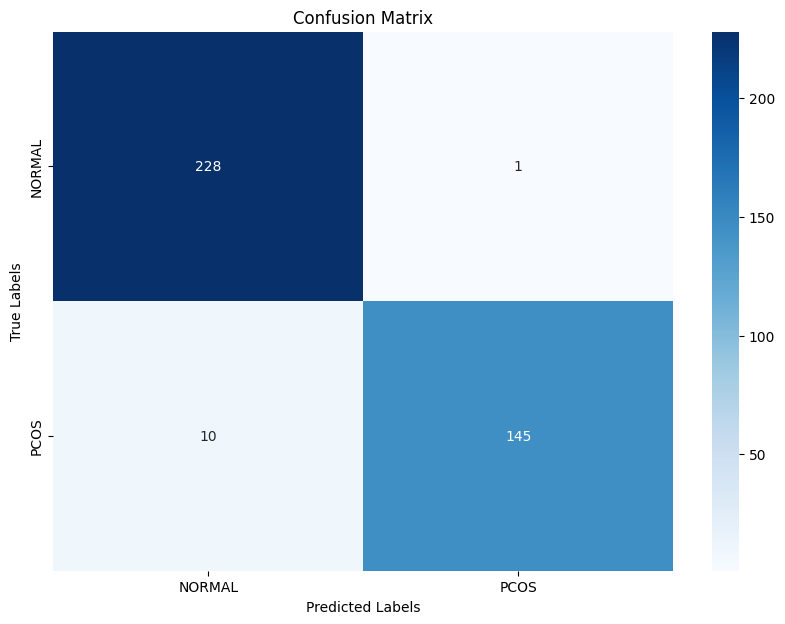

In [ ]:
test_loss_resnet152, test_accuracy_resnet152 = model_resnet152.evaluate(test_generator, steps=len(normalized_test_images) // 32)
print("Test Loss for ResNet152:", test_loss_resnet152)
print("Test Accuracy for ResNet152:", test_accuracy_resnet152)

test_predictions_resnet152 = model_resnet152.predict(test_generator, steps=len(normalized_test_images) // 32)
test_predictions_resnet152 = np.argmax(test_predictions_resnet152, axis=1)

conf_matrix_resnet152 = confusion_matrix(encoded_test_labels[:len(test_predictions_resnet152)], test_predictions_resnet152)
print("Confusion Matrix for ResNet152:")
print(conf_matrix_resnet152)

print("Generating Classification Report for ResNet152...")
class_report_resnet152 = classification_report(encoded_test_labels[:len(test_predictions_resnet152)], test_predictions_resnet152, target_names=le.classes_)
print("Classification Report for ResNet152:")
print(class_report_resnet152)

tn, fp, fn, tp = conf_matrix_resnet152.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Sensitivity (Recall or True Positive Rate) for ResNet152:", sensitivity)
print("Specificity (True Negative Rate) for ResNet152:", specificity)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(conf_matrix_resnet152, le.classes_)

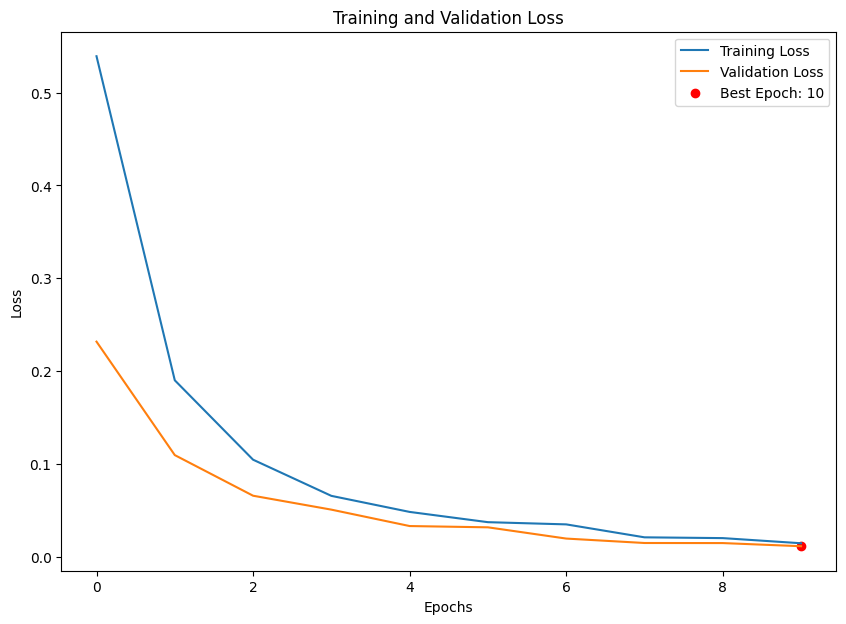

In [ ]:
def plot_loss_curve_with_best_epoch(history, title='Training and Validation Loss'):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    best_epoch = np.argmin(val_loss)
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.scatter(best_epoch, val_loss[best_epoch], color='red', label=f'Best Epoch: {best_epoch+1}')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss_curve_with_best_epoch(history_resnet152)

12/12 [==============================] - 12s 1s/step


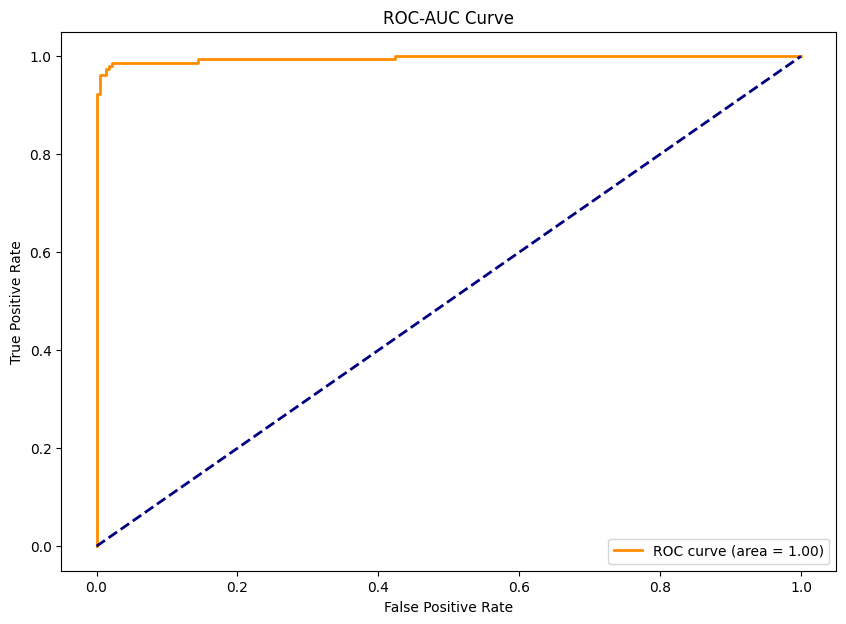

In [ ]:
def plot_roc_auc_curve(model, generator, labels, title='ROC-AUC Curve'):
    y_true = labels[:len(test_predictions_resnet152)]
    y_pred_proba = model.predict(generator, steps=len(normalized_test_images) // 32)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

plot_roc_auc_curve(model_resnet152, test_generator, encoded_test_labels)

**xception**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import os
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def load_data_xception(directory, target_size=(299, 299)):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = Image.open(image_path).convert('L')
            image = image.resize(target_size)
            image = np.stack((image,)*3, axis=-1)
            images.append(np.array(image))
            labels.append(class_name)
    return np.array(images), np.array(labels)

def apply_histogram_equalization_xception(image):
    image_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    image_yuv[:,:,0] = cv2.equalizeHist(image_yuv[:,:,0])
    image_equalized = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
    return image_equalized

train_dir_xception = '/content/drive/MyDrive/Dataset/Train'
test_dir_xception = '/content/drive/MyDrive/Dataset/Test'
train_images_xception, train_labels_xception = load_data_xception(train_dir_xception)
test_images_xception, test_labels_xception = load_data_xception(test_dir_xception)

equalized_train_images_xception = np.array([apply_histogram_equalization_xception(image) for image in train_images_xception])
equalized_test_images_xception = np.array([apply_histogram_equalization_xception(image) for image in test_images_xception])

def normalize_images_xception(image_list):
    normalized_images = []
    for image in image_list:
        normalized_image = image.astype('float32') / 255.0
        normalized_images.append(normalized_image)
    return np.array(normalized_images)

normalized_train_images_xception = normalize_images_xception(equalized_train_images_xception)
normalized_test_images_xception = normalize_images_xception(equalized_test_images_xception)


In [ ]:
le_xception = LabelEncoder()
encoded_train_labels_xception = le_xception.fit_transform(train_labels_xception)
encoded_test_labels_xception = le_xception.transform(test_labels_xception)

train_datagen_xception = ImageDataGenerator()
test_datagen_xception = ImageDataGenerator()

train_generator_xception = train_datagen_xception.flow(normalized_train_images_xception, encoded_train_labels_xception, batch_size=32)
test_generator_xception = test_datagen_xception.flow(normalized_test_images_xception, encoded_test_labels_xception, batch_size=32, shuffle=False)


In [ ]:
base_model_xception = Xception(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))
for layer in base_model_xception.layers:
    layer.trainable = False

x_xception = GlobalAveragePooling2D()(base_model_xception.output)
x_xception = Dense(512, activation='relu')(x_xception)
x_xception = Dropout(0.5)(x_xception)
predictions_xception = Dense(len(le_xception.classes_), activation='softmax')(x_xception)

model_xception = Model(inputs=base_model_xception.input, outputs=predictions_xception)
model_xception.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_xception.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_3[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati

In [ ]:
history_xception = model_xception.fit(
    train_generator_xception,
    steps_per_epoch=len(normalized_train_images_xception) // 32,
    epochs=10,
    validation_data=test_generator_xception,
    validation_steps=len(normalized_test_images_xception) // 32
)

Epoch 1/10
49/49 [==============================] - 59s 1s/step - loss: 0.0629 - accuracy: 0.9717 - val_loss: 0.0443 - val_accuracy: 0.9870
Epoch 2/10
49/49 [==============================] - 55s 1s/step - loss: 4.1615e-04 - accuracy: 1.0000 - val_loss: 0.0417 - val_accuracy: 0.9870
Epoch 3/10
49/49 [==============================] - 58s 1s/step - loss: 2.2334e-04 - accuracy: 1.0000 - val_loss: 0.0467 - val_accuracy: 0.9844
Epoch 4/10
49/49 [==============================] - 56s 1s/step - loss: 1.7624e-04 - accuracy: 1.0000 - val_loss: 0.0423 - val_accuracy: 0.9870
Epoch 5/10
49/49 [==============================] - 56s 1s/step - loss: 1.2183e-04 - accuracy: 1.0000 - val_loss: 0.0350 - val_accuracy: 0.9896
Epoch 6/10
49/49 [==============================] - 53s 1s/step - loss: 1.0632e-04 - accuracy: 1.0000 - val_loss: 0.0424 - val_accuracy: 0.9870
Epoch 7/10
49/49 [==============================] - 55s 1s/step - loss: 7.2106e-05 - accuracy: 1.0000 - val_loss: 0.0384 - val_accuracy: 0.9

In [ ]:

test_loss_xception, test_accuracy_xception = model_xception.evaluate(test_generator_xception, steps=len(normalized_test_images_xception) // 32)
print("Test Loss for Xception:", test_loss_xception)
print("Test Accuracy for Xception:", test_accuracy_xception)

test_predictions_xception = model_xception.predict(test_generator_xception, steps=len(normalized_test_images_xception) // 32)
test_predictions_xception = np.argmax(test_predictions_xception, axis=1)

conf_matrix_xception = confusion_matrix(encoded_test_labels_xception[:len(test_predictions_xception)], test_predictions_xception)
print("Confusion Matrix for Xception:")
print(conf_matrix_xception)

print("Generating Classification Report for Xception...")
class_report_xception = classification_report(encoded_test_labels_xception[:len(test_predictions_xception)], test_predictions_xception, target_names=le_xception.classes_)
print("Classification Report for Xception:")
print(class_report_xception)

tn, fp, fn, tp = conf_matrix_xception.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Sensitivity (Recall or True Positive Rate) for Xception:", sensitivity)
print("Specificity (True Negative Rate) for Xception:", specificity)


12/12 [==============================] - 10s 867ms/step - loss: 0.0425 - accuracy: 0.9870
Test Loss for Xception: 0.04252069070935249
Test Accuracy for Xception: 0.9869791865348816
12/12 [==============================] - 12s 995ms/step
Confusion Matrix for Xception:
[[229   0]
 [  5 150]]
Generating Classification Report for Xception...
Classification Report for Xception:
              precision    recall  f1-score   support

      NORMAL       0.98      1.00      0.99       229
        PCOS       1.00      0.97      0.98       155

    accuracy                           0.99       384
   macro avg       0.99      0.98      0.99       384
weighted avg       0.99      0.99      0.99       384

Sensitivity (Recall or True Positive Rate) for Xception: 0.967741935483871
Specificity (True Negative Rate) for Xception: 1.0


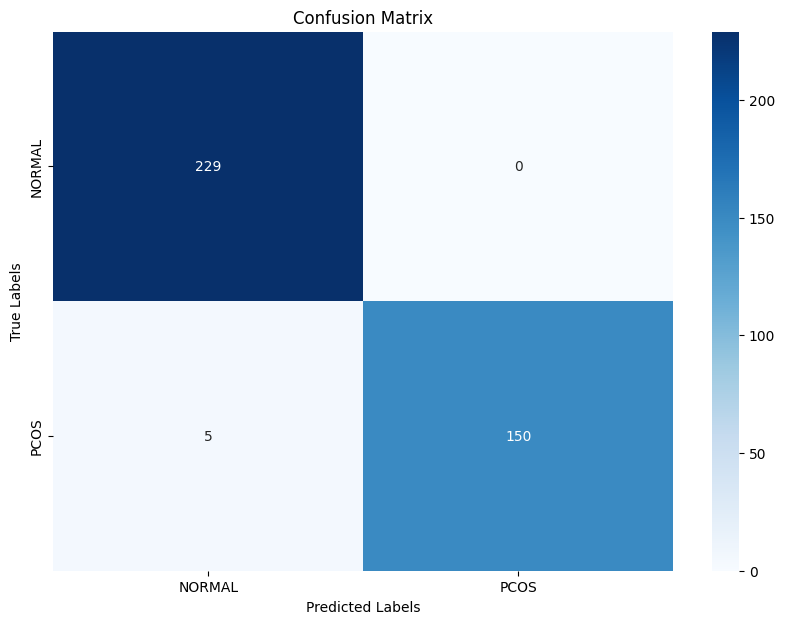

In [ ]:
import seaborn as sns


def plot_confusion_matrix_xception(conf_matrix, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix_xception(conf_matrix_xception, le_xception.classes_)

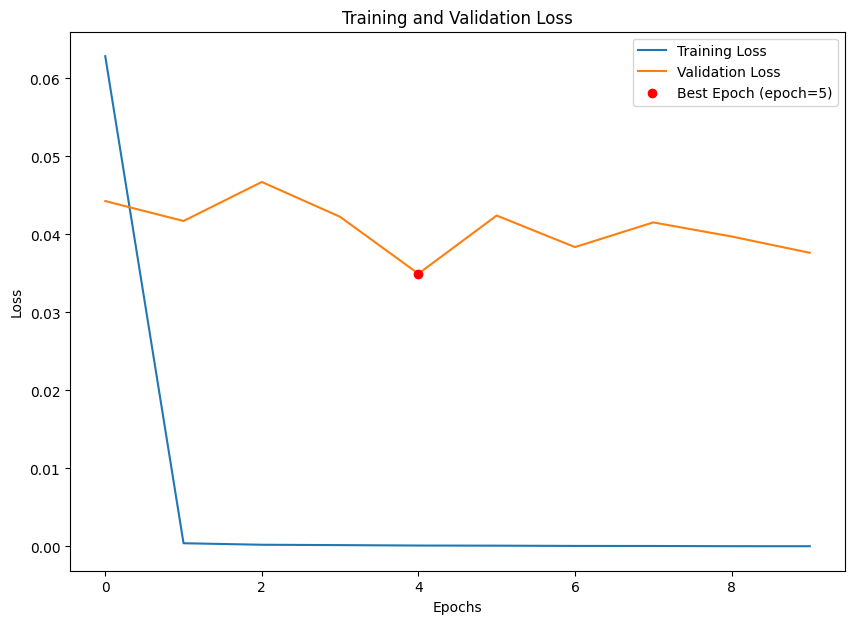

In [ ]:
def plot_loss_curve_with_best_epoch(history, title='Training and Validation Loss'):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    best_epoch = np.argmin(val_loss)
    best_val_loss = val_loss[best_epoch]

    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.scatter(best_epoch, best_val_loss, color='red', label=f'Best Epoch (epoch={best_epoch+1})', zorder=5)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss_curve_with_best_epoch(history_xception)

12/12 [==============================] - 12s 1s/step


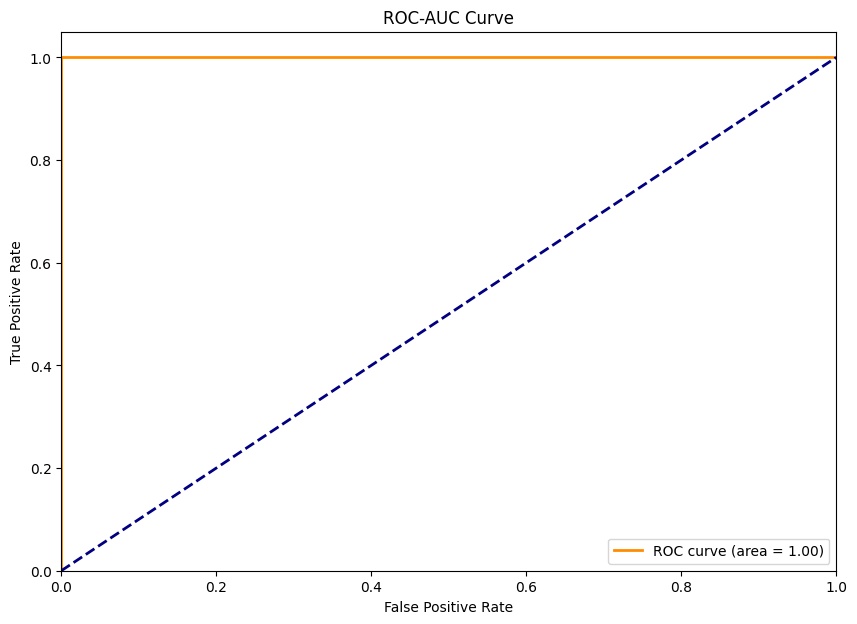

In [ ]:
def plot_roc_auc_curve(model, test_generator, encoded_test_labels, title='ROC-AUC Curve'):
    y_true = encoded_test_labels[:len(test_predictions_xception)]
    y_pred_proba = model.predict(test_generator, steps=len(normalized_test_images_xception) // 32)

    if y_pred_proba.shape[1] == 2:
        y_pred_proba = y_pred_proba[:, 1]

    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

plot_roc_auc_curve(model_xception, test_generator_xception, encoded_test_labels_xception)


**hybrid models**

 **xception+catboost**

In [ ]:
def load_data_xception(directory, target_size=(299, 299)):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = Image.open(image_path).convert('L')
            image = image.resize(target_size)
            image = np.stack((image,) * 3, axis=-1)
            images.append(np.array(image))
            labels.append(class_name)
    return np.array(images), np.array(labels)

def apply_histogram_equalization_xception(image):
    image_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    image_yuv[:, :, 0] = cv2.equalizeHist(image_yuv[:, :, 0])
    image_equalized = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
    return image_equalized

train_dir_xception = '/content/drive/MyDrive/Dataset/Train'
test_dir_xception = '/content/drive/MyDrive/Dataset/Test'
train_images_xception, train_labels_xception = load_data_xception(train_dir_xception)
test_images_xception, test_labels_xception = load_data_xception(test_dir_xception)

equalized_train_images_xception = np.array([apply_histogram_equalization_xception(image) for image in train_images_xception])
equalized_test_images_xception = np.array([apply_histogram_equalization_xception(image) for image in test_images_xception])

def normalize_images_xception(image_list):
    normalized_images = []
    for image in image_list:
        normalized_image = image.astype('float32') / 255.0
        normalized_images.append(normalized_image)
    return np.array(normalized_images)

original_train_images_xception, original_val_images_xception, original_train_labels_xception, original_val_labels_xception = train_test_split(
    equalized_train_images_xception, train_labels_xception, test_size=0.2, random_state=42
)

normalized_train_images_xception = normalize_images_xception(original_train_images_xception)
normalized_val_images_xception = normalize_images_xception(original_val_images_xception)
normalized_test_images_xception = normalize_images_xception(equalized_test_images_xception)

le_xception = LabelEncoder()
encoded_train_labels_xception = le_xception.fit_transform(original_train_labels_xception)
encoded_val_labels_xception = le_xception.transform(original_val_labels_xception)
encoded_test_labels_xception = le_xception.transform(test_labels_xception)

train_datagen_xception = ImageDataGenerator()
val_datagen_xception = ImageDataGenerator()
test_datagen_xception = ImageDataGenerator()

train_generator_xception = train_datagen_xception.flow(normalized_train_images_xception, encoded_train_labels_xception, batch_size=32)
val_generator_xception = val_datagen_xception.flow(normalized_val_images_xception, encoded_val_labels_xception, batch_size=32, shuffle=False)
test_generator_xception = test_datagen_xception.flow(normalized_test_images_xception, encoded_test_labels_xception, batch_size=32, shuffle=False)


In [ ]:
hybrid_model_xception = Xception(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))
for layer in hybrid_model_xception.layers:
    layer.trainable = False

feature_extractor_xception = Model(inputs=hybrid_model_xception.input, outputs=hybrid_model_xception.output)

train_features_xception = feature_extractor_xception.predict(normalized_train_images_xception, batch_size=32)
train_features_xception = train_features_xception.reshape(train_features_xception.shape[0], -1)

val_features_xception = feature_extractor_xception.predict(normalized_val_images_xception, batch_size=32)
val_features_xception = val_features_xception.reshape(val_features_xception.shape[0], -1)

test_features_xception = feature_extractor_xception.predict(normalized_test_images_xception, batch_size=32)
test_features_xception = test_features_xception.reshape(test_features_xception.shape[0], -1)


13/13 [==============================] - 11s 834ms/step


In [ ]:
!pip install Catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc


catboost_classifier = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=4, verbose=10)
catboost_classifier.fit(train_features_xception, encoded_train_labels_xception, eval_set=(val_features_xception, encoded_val_labels_xception))

catboost_probabilities_xception = catboost_classifier.predict_proba(test_features_xception)[:, 1]

catboost_predictions_xception = catboost_classifier.predict(test_features_xception)



0:	learn: 0.4905177	test: 0.5020716	best: 0.5020716 (0)	total: 2.9s	remaining: 4m 46s
10:	learn: 0.0475620	test: 0.0642880	best: 0.0642880 (10)	total: 30.6s	remaining: 4m 7s
20:	learn: 0.0115507	test: 0.0204982	best: 0.0204982 (20)	total: 58.1s	remaining: 3m 38s
30:	learn: 0.0055414	test: 0.0124449	best: 0.0124449 (30)	total: 1m 25s	remaining: 3m 10s
40:	learn: 0.0032781	test: 0.0085710	best: 0.0085710 (40)	total: 1m 53s	remaining: 2m 42s
50:	learn: 0.0027994	test: 0.0079125	best: 0.0079125 (50)	total: 2m 20s	remaining: 2m 15s
60:	learn: 0.0024027	test: 0.0073565	best: 0.0073565 (60)	total: 2m 48s	remaining: 1m 47s
70:	learn: 0.0023949	test: 0.0073456	best: 0.0073456 (69)	total: 3m 15s	remaining: 1m 20s
80:	learn: 0.0020499	test: 0.0064329	best: 0.0064329 (80)	total: 3m 43s	remaining: 52.4s
90:	learn: 0.0019141	test: 0.0065403	best: 0.0064326 (83)	total: 4m 11s	remaining: 24.8s
99:	learn: 0.0014471	test: 0.0059758	best: 0.0059196 (97)	total: 4m 35s	remaining: 0us

bestTest = 0.00591960

CatBoost Accuracy: 0.992462311557789
Confusion Matrix for CatBoost:
[[229   0]
 [  3 166]]
Classification Report for CatBoost:
              precision    recall  f1-score   support

      NORMAL       0.99      1.00      0.99       229
        PCOS       1.00      0.98      0.99       169

    accuracy                           0.99       398
   macro avg       0.99      0.99      0.99       398
weighted avg       0.99      0.99      0.99       398

Sensitivity (Recall or True Positive Rate) for Xception + Catboost: 0.9822485207100592
Specificity (True Negative Rate) for Xception + Catboost: 1.0


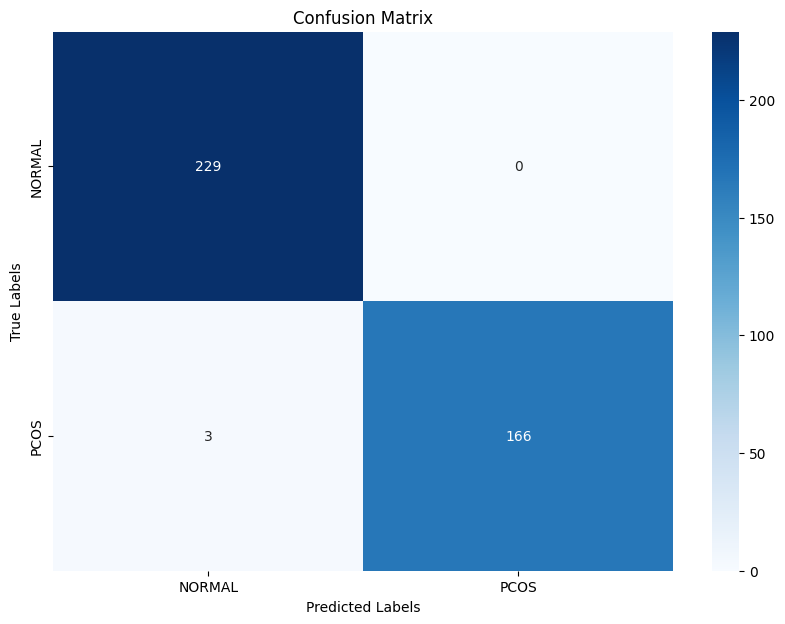

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import os
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
catboost_accuracy_xception = accuracy_score(encoded_test_labels_xception, catboost_predictions_xception)
print(f"CatBoost Accuracy: {catboost_accuracy_xception}")

catboost_confusion_matrix_xception = confusion_matrix(encoded_test_labels_xception, catboost_predictions_xception)
print("Confusion Matrix for CatBoost:")
print(catboost_confusion_matrix_xception)

catboost_classification_report_xception = classification_report(encoded_test_labels_xception, catboost_predictions_xception, target_names=le_xception.classes_)
print("Classification Report for CatBoost:")
print(catboost_classification_report_xception)

tn, fp, fn, tp = catboost_confusion_matrix_xception.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity (Recall or True Positive Rate) for Xception + Catboost:", sensitivity)
print("Specificity (True Negative Rate) for Xception + Catboost:", specificity)

def plot_confusion_matrix_xception(conf_matrix, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix_xception(catboost_confusion_matrix_xception, le_xception.classes_)


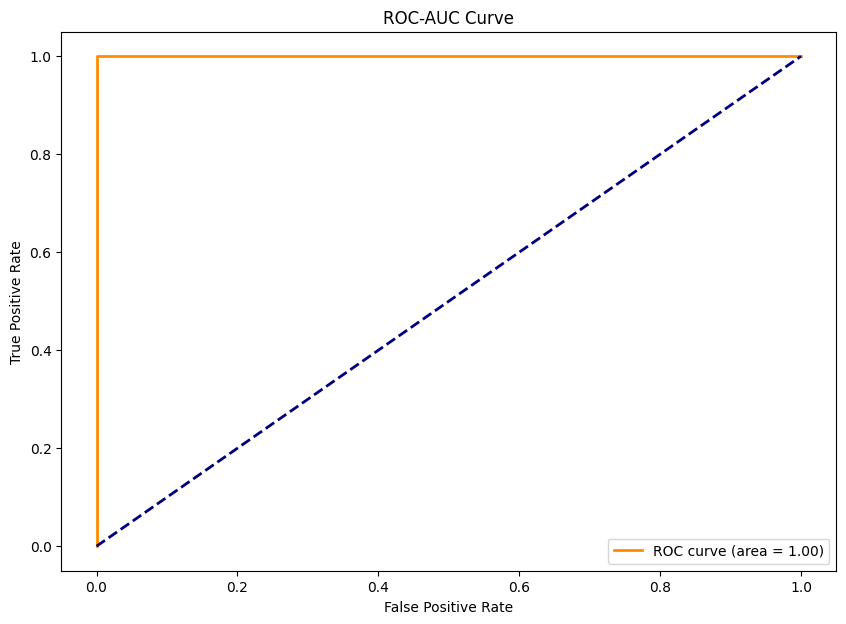

In [ ]:
def plot_roc_auc_curve_xception(encoded_labels, probabilities, title='ROC-AUC Curve'):
    fpr, tpr, _ = roc_curve(encoded_labels, probabilities, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

plot_roc_auc_curve_xception(encoded_test_labels_xception, catboost_probabilities_xception)

**resnet152 + catboost**

In [ ]:
hybrid_model_resnet152 = ResNet152(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
for layer in hybrid_model_resnet152.layers:
    layer.trainable = False

feature_extractor_resnet152 = Model(inputs=hybrid_model_resnet152.input, outputs=hybrid_model_resnet152.output)

train_features_resnet152 = feature_extractor_resnet152.predict(normalized_train_images, batch_size=32)
train_features_resnet152 = train_features_resnet152.reshape(train_features_resnet152.shape[0], -1)

val_features_resnet152 = feature_extractor_resnet152.predict(normalized_val_images, batch_size=32)
val_features_resnet152 = val_features_resnet152.reshape(val_features_resnet152.shape[0], -1)

test_features_resnet152 = feature_extractor_resnet152.predict(normalized_test_images, batch_size=32)
test_features_resnet152 = test_features_resnet152.reshape(test_features_resnet152.shape[0], -1)


13/13 [==============================] - 13s 959ms/step


0:	learn: 0.4969056	test: 0.4961427	best: 0.4961427 (0)	total: 124ms	remaining: 12.2s
10:	learn: 0.0611725	test: 0.0620873	best: 0.0620873 (10)	total: 1.31s	remaining: 10.6s
20:	learn: 0.0184280	test: 0.0229136	best: 0.0229136 (20)	total: 2.5s	remaining: 9.4s
30:	learn: 0.0089317	test: 0.0134729	best: 0.0134729 (30)	total: 3.67s	remaining: 8.18s
40:	learn: 0.0049632	test: 0.0089706	best: 0.0089706 (40)	total: 4.85s	remaining: 6.98s
50:	learn: 0.0040844	test: 0.0077586	best: 0.0077580 (46)	total: 6.02s	remaining: 5.79s
60:	learn: 0.0034097	test: 0.0069778	best: 0.0069778 (58)	total: 7.19s	remaining: 4.6s
70:	learn: 0.0034096	test: 0.0069783	best: 0.0069778 (58)	total: 8.37s	remaining: 3.42s
80:	learn: 0.0034091	test: 0.0069804	best: 0.0069778 (58)	total: 9.55s	remaining: 2.24s
90:	learn: 0.0034089	test: 0.0069812	best: 0.0069778 (58)	total: 10.7s	remaining: 1.06s
99:	learn: 0.0034087	test: 0.0069820	best: 0.0069778 (58)	total: 11.8s	remaining: 0us

bestTest = 0.00697775838
bestIteration

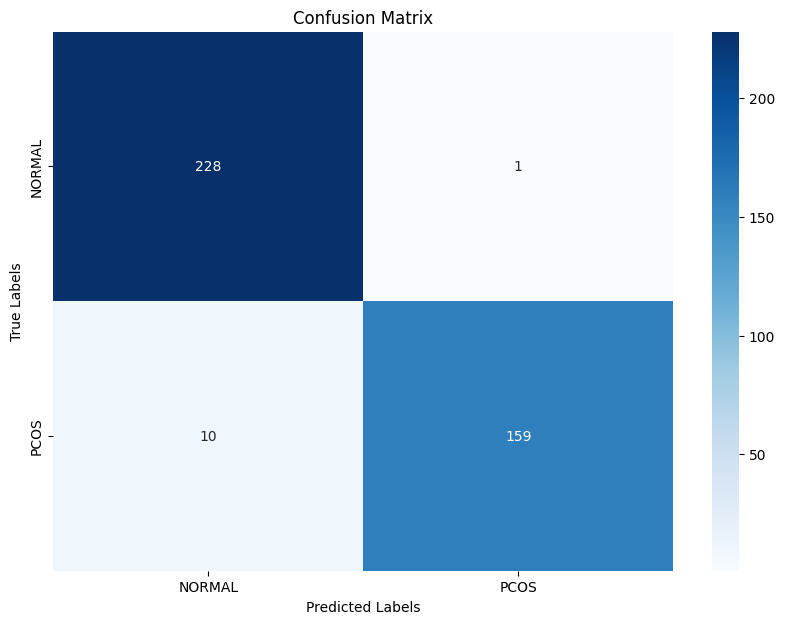

In [ ]:

catboost_classifier = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=4, verbose=10)
catboost_classifier.fit(train_features_resnet152, encoded_train_labels, eval_set=(val_features_resnet152, encoded_val_labels))

catboost_probabilities_resnet = catboost_classifier.predict_proba(test_features_resnet152)[:, 1]

catboost_predictions_resnet = catboost_classifier.predict(test_features_resnet152)

catboost_accuracy_resnet = accuracy_score(encoded_test_labels, catboost_predictions_resnet)
print(f"CatBoost Accuracy (ResNet152): {catboost_accuracy_resnet}")

catboost_confusion_matrix_resnet = confusion_matrix(encoded_test_labels, catboost_predictions_resnet)
print("Confusion Matrix for CatBoost (ResNet152):")
print(catboost_confusion_matrix_resnet)

catboost_classification_report_resnet = classification_report(encoded_test_labels, catboost_predictions_resnet, target_names=le.classes_)
print("Classification Report for CatBoost (ResNet152):")
print(catboost_classification_report_resnet)

tn, fp, fn, tp = catboost_confusion_matrix_resnet.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity (Recall or True Positive Rate) for ResNet152 + Catboost:", sensitivity)
print("Specificity (True Negative Rate) for ResNet152 + Catboost:", specificity)

def plot_confusion_matrix(conf_matrix, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(catboost_confusion_matrix_resnet, le.classes_)

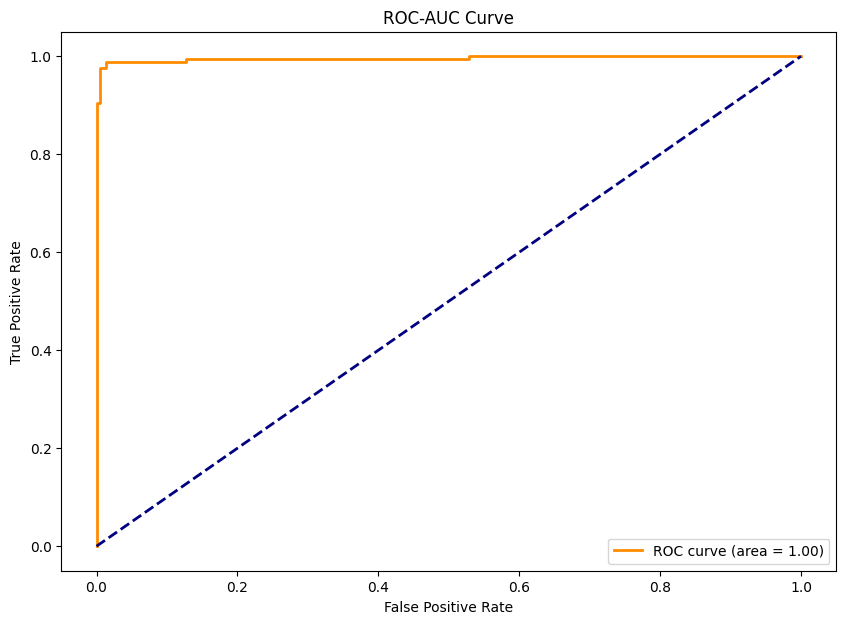

In [ ]:
def plot_roc_auc_curve(encoded_labels, probabilities, title='ROC-AUC Curve'):
    fpr, tpr, _ = roc_curve(encoded_labels, probabilities, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

plot_roc_auc_curve(encoded_test_labels, catboost_probabilities_resnet)

**Nasnetmobile + catboost**

In [ ]:
hybrid_model_nasnet_mobile = NASNetMobile(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

for layer in hybrid_model_nasnet_mobile.layers:
    layer.trainable = False

feature_extractor_nasnet_mobile = Model(inputs=hybrid_model_nasnet_mobile.input, outputs=hybrid_model_nasnet_mobile.output)

train_features_nasnet_mobile = feature_extractor_nasnet_mobile.predict(normalized_train_images, batch_size=32)
train_features_nasnet_mobile = train_features_nasnet_mobile.reshape(train_features_nasnet_mobile.shape[0], -1)

val_features_nasnet_mobile = feature_extractor_nasnet_mobile.predict(normalized_val_images, batch_size=32)
val_features_nasnet_mobile = val_features_nasnet_mobile.reshape(val_features_nasnet_mobile.shape[0], -1)

test_features_nasnet_mobile = feature_extractor_nasnet_mobile.predict(normalized_test_images, batch_size=32)
test_features_nasnet_mobile = test_features_nasnet_mobile.reshape(test_features_nasnet_mobile.shape[0], -1)

catboost_classifier = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=4, verbose=10)
catboost_classifier.fit(train_features_nasnet_mobile, encoded_train_labels, eval_set=(val_features_nasnet_mobile, encoded_val_labels))

catboost_probabilities = catboost_classifier.predict_proba(test_features_nasnet_mobile)[:, 1]


13/13 [==============================] - 2s 152ms/step
0:	learn: 0.5792634	test: 0.5775265	best: 0.5775265 (0)	total: 561ms	remaining: 55.5s
10:	learn: 0.0908385	test: 0.0974590	best: 0.0974590 (10)	total: 6.12s	remaining: 49.5s
20:	learn: 0.0251930	test: 0.0307563	best: 0.0307563 (20)	total: 11.7s	remaining: 44s
30:	learn: 0.0101960	test: 0.0141560	best: 0.0141560 (30)	total: 17.3s	remaining: 38.5s
40:	learn: 0.0051301	test: 0.0084242	best: 0.0084242 (40)	total: 22.9s	remaining: 32.9s
50:	learn: 0.0030166	test: 0.0050856	best: 0.0050856 (50)	total: 28.5s	remaining: 27.4s
60:	learn: 0.0019701	test: 0.0037629	best: 0.0037629 (60)	total: 34.1s	remaining: 21.8s
70:	learn: 0.0015451	test: 0.0029977	best: 0.0029977 (70)	total: 39.7s	remaining: 16.2s
80:	learn: 0.0012534	test: 0.0024340	best: 0.0024340 (80)	total: 45.3s	remaining: 10.6s
90:	learn: 0.0012007	test: 0.0023797	best: 0.0023797 (90)	total: 50.9s	remaining: 5.03s
99:	learn: 0.0011005	test: 0.0022271	best: 0.0022271 (99)	total: 56s	

CatBoost Accuracy: 0.9371859296482412
Confusion Matrix for CatBoost:
[[229   0]
 [ 25 144]]
Classification Report for CatBoost:
              precision    recall  f1-score   support

      NORMAL       0.90      1.00      0.95       229
        PCOS       1.00      0.85      0.92       169

    accuracy                           0.94       398
   macro avg       0.95      0.93      0.93       398
weighted avg       0.94      0.94      0.94       398

Sensitivity (Recall or True Positive Rate) for NASNetMobile + Catboost: 0.8520710059171598
Specificity (True Negative Rate) for NASNetMobile + Catboost: 1.0


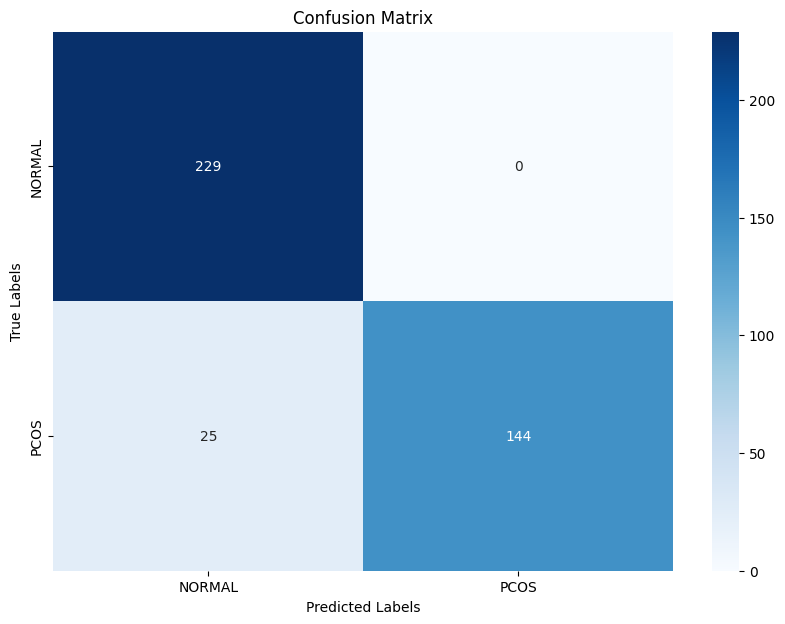

In [ ]:
catboost_predictions = catboost_classifier.predict(test_features_nasnet_mobile)

catboost_accuracy = accuracy_score(encoded_test_labels, catboost_predictions)
print(f"CatBoost Accuracy: {catboost_accuracy}")

catboost_confusion_matrix = confusion_matrix(encoded_test_labels, catboost_predictions)
print("Confusion Matrix for CatBoost:")
print(catboost_confusion_matrix)

catboost_classification_report = classification_report(encoded_test_labels, catboost_predictions, target_names=le.classes_)
print("Classification Report for CatBoost:")
print(catboost_classification_report)

tn, fp, fn, tp = catboost_confusion_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity (Recall or True Positive Rate) for NASNetMobile + Catboost:", sensitivity)
print("Specificity (True Negative Rate) for NASNetMobile + Catboost:", specificity)

def plot_confusion_matrix(conf_matrix, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(catboost_confusion_matrix, le.classes_)


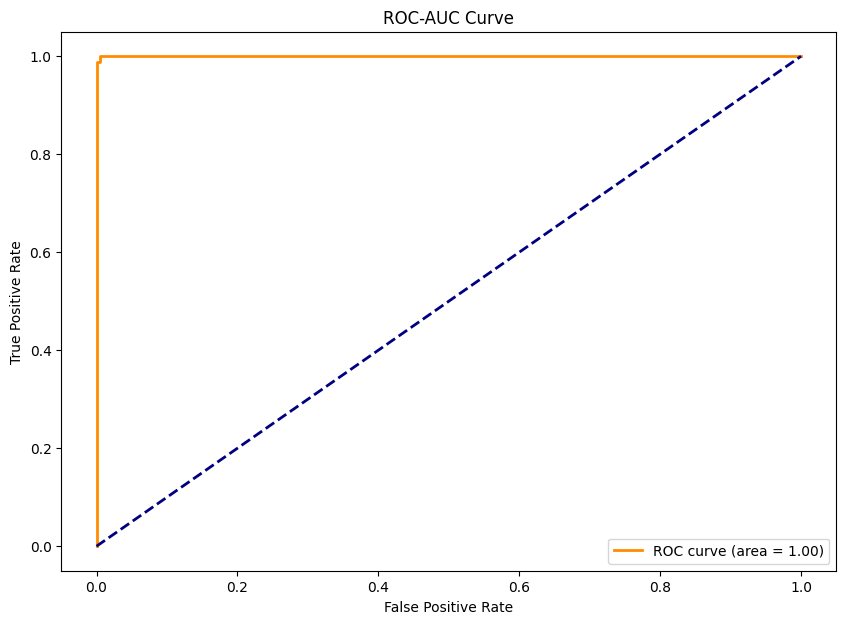

In [ ]:
def plot_roc_auc_curve(encoded_labels, probabilities, title='ROC-AUC Curve'):
    fpr, tpr, _ = roc_curve(encoded_labels, probabilities, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

plot_roc_auc_curve(encoded_test_labels, catboost_probabilities)